# Deep Learning Models
**Román Alberto Vélez Jiménez**, roman.velez.jimenez@gmail.com

- Notebook to explore tha main database of the EPL games created previously in R for the authors bachelor's thesis.

- The notebook is divided in two parts:
  1. Select the best set of variables to predict the probabilities of the outcomes of the games.
  2. Train, validate and test distinct neural networks for the predictions.

- All is made with tensorflow-keras.

-  Remember to change manually the .ipynb to a TPU processing; however, it doesn't improve time performance significantly.



# Functions, Libraries and Updates

In this chunks we clone Roman's thesis repository to obtain the databases. As well, install, update and import necessary libraries.

## Get .py files and data from GitHub Repo

Clone the entire repo to a local file.

In [4]:
# Clone the entire repo.
!git clone -l -s https://github.com/romanAVJ/Optimal_Bets_PremierLeague.git cloned-repo

# move to folder "cloned repo"
%cd cloned-repo

fatal: destination path 'cloned-repo' already exists and is not an empty directory.
/Users/conorlong/Desktop/cloned-repo


## Install, Update & Import libraries

In [6]:
# install & update libraries
# adjustText
!pip install adjustText

!pip install keras-tuner --upgrade

!pip uninstall scikit-learn -y
!pip install -U scikit-learn
!pip install xgboost==1.7.5
!pip install tensorflow
!pip install numpy==1.26.4
#!pip uninstall sklearn -y
#!pip install -U sklearn

# import
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

import os
import random

from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.ticker as mtick

from sklearn import metrics as sk_metrics
from scipy.stats import norm
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/25/92/ee1d7a00bb6b8c55755d4984fd82608603a3cc59959245068ce32e7fb808/scikit_learn-1.6.1-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Using cached scikit_learn-1.6.1-cp311-cp311-macosx_12_0_arm64.whl.metadata (31 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-macosx_12_0_arm64.whl (11.1 MB)


## Own functions

Generate own functions to make easier and more neat the script.

In [86]:
def _reset_random_seeds(seed):
    """
    Reset random seed for Numpy, TensorFlow and Random

    Parameters
    ----------
    seed : int

    Returns
    -------
    None.

    """
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    return()

def get_dummies_results(df, var='y', prefix='y'):
    """
    One hot encoding

    Parameters
    ----------
    df : Dataframe
        Dataframe with the variable to modify
    var : char, optional
        Name of the column of the variable to dummies. The default is 'y'.
    prefix : char, optional
        Prefix of the dummies. The default is 'y'.

    Returns
    -------
    Dataframe df with the dummies of 'var' with the prefix 'prefix'

    """

    # working data frame
    df_work = df.copy()

    # one hot encode results
    y = pd.get_dummies(df_work[var], prefix=prefix, drop_first=False, dtype=int)
    names_y = y.columns.values

    # append to dataframe
    df_work[names_y] = y

    # reorder columns
    columns_names = df_work.columns.values
    columns_names = np.concatenate([names_y, columns_names[:-3]])
    df_work = df_work[columns_names]

    # drop result
    df_work.drop(columns=var, inplace=True)

    return(df_work, list(names_y))

def split_trainvaltest(df, queries, objective_var='y', var='x'):
    """
    Split a dataframe in train/validation/test

    Parameters
    ----------
    df : Dataframe
    queries : dictionary
        SQL like query to the database. The key name is the name of the
        dataframe that would be saved.
    objective_var : char, optional
        Name of the objective variable. The default is 'y'.
    var : list, string, optional
        List/stringo f the covariables column(s). The default is 'x'.

    Returns
    -------
    Dictionary with the

    """
    # working dataframe
    df_work = df.copy()

    # get train, validation and test
    dbb = {}
    for k,v in queries.items():
        df_subset = df_work.query(v)

        # save objective and covariables in dataframe
        dbb[k] = {'y': df_subset[objective_var], 'X': df_subset[var]}

    return(dbb)

def _printProgressBar (
        iteration, total, prefix = 'progress:',
        suffix = 'complete', decimals = 1, length = 10,
        fill = '█', printEnd = "\r"
        ):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)

    Function made by Greenstick
    https://stackoverflow.com/a/34325723
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total:
        print()

def blliCI_willson(theta, n, alpha=0.05):

    """
    Wilson Confidence Interval for a Blli parameter

    Parameters
    ----------
    theta : float
        Estimated parameter
    n : int
        Number of observations
    alpha : float, optional
        Degree of significance. The default is 0.05.

    Returns
    -------
    tuple of floats. Lower and upper 1-alpha % confidence interval.

    """
    # get normal quantile
    z = norm.ppf(1-alpha/2)
    z2 = z**2
    # constant
    ci_const = (1/(1 + z2/n)) * (theta + z2/(2*n))
    ci_openess = (z/(1 + z2/n)) * np.sqrt(theta * (1 - theta)/n + z2/(4*n**2))

    ci_lower = ci_const - ci_openess
    ci_upper = ci_const + ci_openess

    return(ci_lower, ci_upper)

def tidy_bdd(df, queries, objective_var='y', var='x'):
    # working data frame
    df_work = df.copy()

    # get dummies
    df_work, names_y = get_dummies_results(df_work, var=objective_var, prefix=objective_var)

    # mutate matchweek to normalize it (lost generalization in functions)
    df_work['matchweek'] = df_work.groupby('season')['matchweek'].\
        transform(lambda x: (x - min(x))/(max(x) - min(x)))

    # get train, validation and test
    dbb = split_trainvaltest(df_work, queries, objective_var=names_y, var=var)

    return(dbb)

#%% neural networks
def build_model(dbb, lambda_val=0, metric_stop='accuracy', seed=42, return_model=False):
    """
    Build keras shallow lasso neural network. Train and validate data in the
    database given (dbb).

    The kernel initializer is GlorotNormal.
    The validation threshold is 0.01 in loss with 10 cycles of patience. It restores
    the best weights.

    Parameters
    ----------
    dbb : dict
        Dictionary of dictionaries. First dictionary should have a 'train'
        and 'validation' keys, which are the databases where the model should
        fit and validate (test) the data. Each dictionary should have a 'X' and 'y' keys,
        which are the covariables and the objective variables, respectively.
    lambda_val : float, optional
        Lasso penalization magnitude. The default is 0.
    metric_stop : str, optional
        The neural network stops training in the next 10 epochs where there
        isn't an observed improvement. The default is 'accuracy'.
    seed : int, optional
        Random seed generator. The default is 42.

    Returns
    -------
    - err_train: array
        [0]: Loss
        [1]: Accuracy

    - err_val: array
        [0]: Loss
        [1]: Accuracy

    - theta: dict (covars x layers)
        Weight matrix of the neural network per layer

    """
    # init randomness
    _reset_random_seeds(seed=seed)

    # get train database
    X_train=dbb['train']['X']
    Y_train=dbb['train']['y']

    # number of classes, covars and observations
    n_class = Y_train.shape[1] # num columns
    n_obs, n_covars = X_train.shape

    # create model
    model = keras.Sequential()
    model.add(
        keras.layers.Dense(
            units= n_class,
            activation='softmax',
            # initialization of weights
            kernel_initializer=keras.initializers.GlorotNormal(),
            # lasso punishment
            kernel_regularizer=keras.regularizers.l1(float(lambda_val)),
            # kwargs
            dtype=np.float32 # Changed dtype to float32
        )
    )

    # compile model
    model.compile(
            optimizer='Nadam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    # early stopping
    if metric_stop == 'accuracy':
        # train model
        early_stop = keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            min_delta=0,
            patience=10,
            restore_best_weights=True
        )
    else:
        # train model
        early_stop = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.01,
            patience=10,
            restore_best_weights=True
        )

    # train model
    model.fit(
        x=X_train.astype(np.float32), # Changed input data type to float32
        y=Y_train.astype(np.float32), # Changed input data type to float32
        epochs=1000,
        batch_size=n_obs, #complete gradient
        shuffle=False,
        verbose=0,
        callbacks=[early_stop],
        validation_data=(dbb['validation']['X'].astype(np.float32), dbb['validation']['y'].astype(np.float32)), # Changed input data type to float32
        validation_batch_size=len(dbb['validation']['X'])    #complete gradient
    )

    # get errors (loss and accuracy)
    err_train = model.evaluate(X_train.astype(np.float32), Y_train.astype(np.float32), verbose=0) # Changed input data type to float32
    err_val = model.evaluate(dbb['validation']['X'].astype(np.float32), dbb['validation']['y'].astype(np.float32), verbose=0) # Changed input data type to float32
    theta = model.get_weights()

    if return_model:
        return(model)
    else:
        return(err_train, err_val, theta)


def eval_LassoTCV(
        dbb, nsplit_cv=5, ntest_cv=1,
        lambda_val=0, metric='accuracy',
        seed=42, verbose=True
        ):
    """
    Evaluate dbb (train and validation) in a simple temporal cross validation

    Parameters
    ----------
    dbb : dict
        Dictionary of dictionaries. First dictionary should have a 'train'
        and 'validation' keys, which are the databases where the model should
        fit and validate (test) the data. Each dictionary should have a 'X' and 'y' keys,
        which are the covariables and the objective variables, respectively.
    nsplit_cv : int, optional
        Number of cross validation splits. The default is 5.
    ntest_cv : int, optional
        Number of cross validations evaluated. The default is 1 (all the database).
    lambda_val : float, optional
         Lasso penalization magnitude. The default is 0.
    metric : TYPE, optional
        The neural network stops training in the next 10 epochs where there
        isn't an observed improvement. The default is 'accuracy'.
    seed : int, optional
         Random seed generator. The default is 42.
    verbose : boolean, optional
        If True then it will print progress in evaluation. The default is True.

    Returns
    -------
    - loss_stats: Dataframe
        Dataframe with sample mean & standard deviation

    - acc_stats: Dataframe
        Dataframe with sample mean, standard deviation & Willson confidence intervals
        for bernoulli distribution

    """

    # merge train and validation in one dataframe
    X_list = [v2 for k1, dics in dbb.items() if k1 != 'test' for k2, v2 in dics.items() if k2 == "X"]
    Y_list = [v2 for k1, dics in dbb.items() if k1 != 'test' for k2, v2 in dics.items() if k2 == "y"]

    X_data = pd.concat(X_list)
    Y_data = pd.concat(Y_list)

    # save
    array_errors = np.zeros((nsplit_cv, 2))

    # split data in nsplit_cv-folds
    if verbose:
        print("fold: ", end='')

    tscv = TimeSeriesSplit(n_splits=nsplit_cv, test_size=ntest_cv, gap=0)
    i = 0
    for index_train, index_val in tscv.split(X_data):
        # save train/val database
        dbb_val = {
            'train': {
                'X': X_data.iloc[index_train],
                'y': Y_data.iloc[index_train]
            },
            'validation': {
                'X': X_data.iloc[index_val],
                'y': Y_data.iloc[index_val]
            }
        }

        # get a look in the number of iterations
        if verbose:
            print(str(i+1) + ", ", end="")

        # train model and get validation loss and accuracy
        _, err_val, _ = build_model(dbb_val, lambda_val=lambda_val, metric_stop=metric, seed=seed)

        # append metrics
        array_errors[i] = np.array(err_val)

        # update index
        i += 1


    # get statistics of the metrics
    # loss
    mean_loss = np.mean(array_errors[:, 0], axis=0)
    std_loss = np.std(array_errors[:, 0], axis=0)

    # acc
    mean_acc = np.mean(array_errors[:, 1], axis=0)
    std_acc = np.std(array_errors[:, 1], axis=0)

    # return
    loss_stats = np.array((mean_loss, std_loss))
    acc_stats = np.array((mean_acc, std_acc))

    return(loss_stats, acc_stats)

def get_lambdaLassoTCV(
        dbb, lambdas=np.power(10, np.linspace(1, -5)), nsplit_cv=5,
        ntest_cv=1,  metric='accuracy', verbose=True, seed=48
        ):
    """
    Get best lambda for lasso penalization in a temporal cross validation. As well,
    get the last lambda within one standard deviation and the last lambda which its
    confidence interval includes the best lambda.

    Parameters
    ----------
    dbb : dict
        Dictionary of dictionaries. First dictionary should have a 'train'
        and 'validation' keys, which are the databases where the model should
        fit and validate (test) the data. Each dictionary should have a 'X' and 'y' keys,
        which are the covariables and the objective variables, respectively.
    lambdas : array, optional
        The search space grid of the best posible lambda.
        The default is np.power(10, np.linspace(1, -5)).
    nsplit_cv : int, optional
        Number of cross validation splits. The default is 5.
    ntest_cv : int, optional
        Number of cross validations evaluated. The default is 1 (all the database).
    lambda_val : float, optional
         Lasso penalization magnitude. The default is 0.
    metric : TYPE, optional
        The neural network stops training in the next 10 epochs where there
        isn't an observed improvement. The default is 'accuracy'.
    seed : int, optional
         Random seed generator. The default is 42.
    verbose : boolean, optional
        If True then it will print progress in evaluation. The default is True.

    Returns
    -------
    Dictionary. The keys are 'stats' and 'lambdas' which includes the dataframes
    of the validation loss and accuracy per lambda and the

    """

    # print loops
    if verbose:
        print("temporal CV of " + str(nsplit_cv) + " folds\n\n")

    # save accuracy and loss
    df_lossstats = pd.DataFrame(columns=("mean_loss", "std_loss"))
    df_accstats = pd.DataFrame(columns=("mean_acc", "std_acc"))

    n_lambdas = len(lambdas)

    # train and get best lambda model
    for i, lambd in enumerate(lambdas):
        # print number of iteration
        if verbose and i % 5 == 0:
            print('\n\ntraining model no.' + str(i+1) + ' of ' + str(n_lambdas))

        # train and test model for each lambda in temporal cross validation
        df_lossstats.loc[i], df_accstats.loc[i] = eval_LassoTCV(
            dbb,
            nsplit_cv=nsplit_cv,
            ntest_cv=ntest_cv,
            lambda_val=lambd,
            metric=metric,
            seed=seed
        )

    df_lossstats["lambdas"] = lambdas
    df_accstats["lambdas"] = lambdas

    # get best lambda
    imax = df_accstats['mean_acc'].argmax()
    best_acc = df_accstats.loc[imax, 'mean_acc']
    lambda_opt = lambdas[imax]

    # get best sparser model lambda at one std
    acc_1std = df_accstats.loc[imax:,"mean_acc"] + df_accstats.loc[imax:,"std_acc"]
    imax_sparse_std = np.where(best_acc <= acc_1std)[0][-1] + imax
    lambda_sparse_std = lambdas[imax_sparse_std]

    dic_out = {
        'stats': {
            'loss': df_lossstats,
            'acc': df_accstats
        },
        'lambdas': {
            'optimal': lambda_opt,
            'sparser_1std': lambda_sparse_std
        }
    }
    return(dic_out)

def get_lassoWeights(
        dbb, lambdas=np.power(10, np.linspace(1, -5)), metric='accuracy',
        verbose=True, seed=48
        ):
    """
    Compute the train and validation accuracy, loss and weights per value of lambda
    for ALL the train set

    Parameters
    ----------
    dbb : dict
        Dictionary of dictionaries. First dictionary should have a 'train'
        and 'validation' keys, which are the databases where the model should
        fit and validate (test) the data. Each dictionary should have a 'X' and 'y' keys,
        which are the covariables and the objective variables, respectively.
    lambdas : array, optional
        The search space grid of the best posible lambda.
        The default is np.power(10, np.linspace(1, -5)).
    metric : TYPE, optional
        The neural network stops training in the next 10 epochs where there
        isn't an observed improvement. The default is 'accuracy'.
    seed : int, optional
         Random seed generator. The default is 42.
    verbose : boolean, optional
        If True then it will print progress in evaluation. The default is True.

    Returns
    -------
    Dictionary. A dataframe of the error stats per lambda. A dictionary of the
    weights per layer per lambda value.

    """

    # save accuracy and loss
    array_errors = np.zeros((len(lambdas), 5))
    dic_weights = {}
    n_lambdas = len(lambdas)

    # train and get best lambda model
    if verbose:
        _printProgressBar(0, n_lambdas)

    for i, lambd in enumerate(lambdas):
        # print number of iteration
        if verbose:
            _printProgressBar(i + 1, n_lambdas)

        # train and test model for each lambda
        err_train, err_val, theta = build_model(dbb, lambda_val=lambd, metric_stop=metric, seed=seed)

        # append values
        # row by: lambda, loss train, loss val, accuracy train, accuracy validation
        array_errors[i] = np.array([lambd, err_train[0], err_val[0], err_train[1], err_val[1]])
        dic_weights['lambda_' + str(i+1)] = {'W': theta[0], 'b': theta[1]}

    # get best lambda
    df_errors = pd.DataFrame(
        array_errors,
        columns=['lambdas', 'train_loss', 'val_loss', 'train_acc', 'val_acc']
    )


    dic_out = {
        'df_lambdas': df_errors,
        'dic_thetas': dic_weights
    }
    return(dic_out)

#%% neural models
def build_model_elastic(hp):
    """
    Build Elastic Net deep models with hyperparameter tunning
    Actually, the hyperparameters for tunning are:
        1. penalization (lambda) per layer
        2. convexity between lasso and ridge (lambda)
        3. number of neurons per layer
        4. learning rate

    Parameters
    ----------
    hp : hyperparam selector


    Returns
    -------
    tunners grid
    """
    # init randomness
    _reset_random_seeds(8)
    n_covars = 21
    n_l = 4

    #### hyper params ####
    # lambda penalization
    dic_lambdas = {
        'layer' + str(i+1): hp.Float(
          name='elastic_lambda_l' + str(i+1),
          min_value=1e-4,
          max_value=1e-2
        )
        for i in range(n_l)
    }

    # alpha (convex combination between lasso & ridge)
    dic_alphas = {
        'layer' + str(i+1): hp.Float(
          name='elastic_alpha_l' + str(i+1),
          min_value=0,
          max_value=1,
          default=0.5
        ) for i in range(n_l)
    }

    # number of neurons
    # create a funnel architecture
    dic_units = dict()
    for i in range(n_l - 1):
      if i == 0:
        dic_units['layer1'] = hp.Int(
          name='units_l1',
          min_value=n_covars,
          max_value=n_covars*2,
          step=4,
          default=n_covars # initial value
        )
      else:
        dic_units['layer' + str(i+1)] = hp.Int(
          name='units_l' + str(i+1),
          min_value=dic_units['layer' + str(i)],
          max_value=dic_units['layer' + str(i)]*2,
          step=4,
          default=dic_units['layer' + str(i)] # initial value
        )

    # learning rate
    lr_r = hp.Choice(
        name = "lr",
        values = [1e-2, 1e-3, 1e-4]
      )

    #### create model ####
    model = keras.Sequential()
    # layers
    for i in range(n_l - 1):
      ikey = str(i+1)
      model.add(
          keras.layers.Dense(
              units=dic_units['layer' + ikey],
              activation='relu',
              kernel_initializer='he_normal',
              kernel_regularizer=keras.regularizers.l1_l2(
                  l1=dic_lambdas['layer' + ikey] * dic_alphas['layer' + ikey],     # Hastie & Tibshiranie formulation of elastic net
                  l2=dic_lambdas['layer' + ikey] * (1 - dic_alphas['layer' + ikey]) / 2  # Hastie & Tibshiranie formulation of elastic net
                )
          )
      )

    # final layer
    model.add(
        keras.layers.Dense(
          units=3, # three final classes
          activation='softmax',
          kernel_initializer=keras.initializers.GlorotNormal(),
          kernel_regularizer=keras.regularizers.l1_l2(
              l1=dic_lambdas['layer' + str(n_l)] * dic_alphas['layer' + str(n_l)],
              l2=dic_lambdas['layer' + str(n_l)] * (1 - dic_alphas['layer' + str(n_l)]) / 2
            )
        )
    )

    # compile model
    model.compile(
          optimizer=keras.optimizers.Nadam(learning_rate=lr_r),
          loss='categorical_crossentropy',
          metrics=['accuracy']
      )

    return model

def build_model_lasso(hp):
    """
    Lasso deep models with hyperparameter tunning
    Actually, the hyperparameters for tunning are:
        1. penalization (lambda) per layer
        2. number of neurons per layer
        3. learning rate

    Parameters
    ----------
    hp : hyperparam selector


    Returns
    -------
    tunners grid
    """
    # init randomness
    _reset_random_seeds(8)
    n_covars = 21
    n_l = 4

    #### hyper params ####
    # lambda penalization
    dic_lambdas = {
        'layer' + str(i+1): hp.Float(
          name='elastic_lambda_l' + str(i+1),
          min_value=1e-4,
          max_value=1e-2
        )
        for i in range(n_l)
    }

    # number of layers
    # create a funnel architecture
    dic_units = dict()
    for i in range(n_l - 1):
      if i == 0:
        dic_units['layer1'] = hp.Int(
          name='units_l1',
          min_value=n_covars,
          max_value=n_covars*2,
          step=4,
          default=n_covars # initial value
        )
      else:
        dic_units['layer' + str(i+1)] = hp.Int(
          name='units_l' + str(i+1),
          min_value=dic_units['layer' + str(i)],
          max_value=dic_units['layer' + str(i)]*2,
          step=4,
          default=dic_units['layer' + str(i)] # initial value
        )

    # learning rate
    lr_r = hp.Choice(
        name = "lr",
        values = [1e-2, 1e-3, 1e-4]
      )

    #### create model ####
    model = keras.Sequential()
    # layers
    for i in range(n_l - 1):
      ikey = str(i+1)
      model.add(
          keras.layers.Dense(
              units=dic_units['layer' + ikey],
              activation='relu',
              kernel_initializer='he_normal',
              kernel_regularizer=keras.regularizers.l1(dic_lambdas['layer' + ikey])
          )
      )

    # final layer
    model.add(
        keras.layers.Dense(
          units=3, # three final classes
          activation='softmax',
          kernel_initializer=keras.initializers.GlorotNormal(),
          kernel_regularizer=keras.regularizers.l1(dic_lambdas['layer' + ikey])
        )
    )

    # compile model
    model.compile(
          optimizer=keras.optimizers.Nadam(learning_rate=lr_r),
          loss='categorical_crossentropy',
          metrics=['accuracy']
      )

    return model

def build_model_ridge(hp):
    """
    Ridge deep models with hyperparameter tunning
    Actually, the hyperparameters for tunning are:
        1. penalization (lambda) per layer
        2. number of neurons per layer
        3. learning rate

    Parameters
    ----------
    hp : hyperparam selector


    Returns
    -------
    tunners grid
    """
    # init randomness
    _reset_random_seeds(8)
    n_covars = 21
    n_l = 4


    #### hyper params ####
    # lambda penalization
    dic_lambdas = {
        'layer' + str(i+1): hp.Float(
          name='elastic_lambda_l' + str(i+1),
          min_value=1e-4,
          max_value=1e-2
        )
        for i in range(n_l)
    }

    # number of neurons
    # create a funnel architecture
    dic_units = dict()
    for i in range(n_l - 1):
      if i == 0:
        dic_units['layer1'] = hp.Int(
          name='units_l1',
          min_value=n_covars,
          max_value=n_covars*2,
          step=4,
          default=n_covars # initial value
        )
      else:
        dic_units['layer' + str(i+1)] = hp.Int(
          name='units_l' + str(i+1),
          min_value=dic_units['layer' + str(i)],
          max_value=dic_units['layer' + str(i)]*2,
          step=4,
          default=dic_units['layer' + str(i)] # initial value
        )

    # learning rate
    lr_r = hp.Choice(
        name = "lr",
        values = [1e-2, 1e-3, 1e-4]
      )

    #### create model ####
    model = keras.Sequential()
    # layers
    for i in range(n_l - 1):
      ikey = str(i+1)
      model.add(
          keras.layers.Dense(
              units=dic_units['layer' + ikey],
              activation='relu',
              kernel_initializer='he_normal',
              kernel_regularizer=keras.regularizers.l2(dic_lambdas['layer' + ikey])
          )
      )

    # final layer
    model.add(
        keras.layers.Dense(
          units=3, # three final classes
          activation='softmax',
          kernel_initializer=keras.initializers.GlorotNormal(),
          kernel_regularizer=keras.regularizers.l2(dic_lambdas['layer' + ikey])
        )
    )

    # compile model
    model.compile(
          optimizer=keras.optimizers.Nadam(learning_rate=lr_r),
          loss='categorical_crossentropy',
          metrics=['accuracy']
      )

    return model

def build_model_dropout(hp):
    """
    Build Drop-Out deep models with hyperparameter tunning
    Actually, the hyperparameters for tunning are:
        1. dropout rate per layer
        2. number of neurons per layer
        3. learning rate

    Parameters
    ----------
    hp : hyperparam selector


    Returns
    -------
    tunners grid
    """
    # init randomness
    _reset_random_seeds(8)
    n_covars = 21
    n_l = 4

    #### hyper params ####
    # dropout
    dic_dropout_rate = {
        'layer' + str(i+1): hp.Float(
          name='rate_l' + str(i+1),
          min_value=1e-6,
          max_value=0.5,
          sampling='log'
          )
        for i in range(n_l - 1)
    }

    # number of layers
    # create a funnel architecture
    dic_units = dict()
    for i in range(n_l - 1):
      if i == 0:
        dic_units['layer1'] = hp.Int(
          name='units_l1',
          min_value=n_covars,
          max_value=n_covars*2,
          step=4,
          default=n_covars # initial value
        )
      else:
        dic_units['layer' + str(i+1)] = hp.Int(
          name='units_l' + str(i+1),
          min_value=dic_units['layer' + str(i)],
          max_value=dic_units['layer' + str(i)]*2,
          step=4,
          default=dic_units['layer' + str(i)] # initial value
        )

    # learning rate
    lr_r = hp.Choice(
        name = "lr",
        values = [1e-2, 1e-3, 1e-4]
      )

    #### create model ####
    model = keras.Sequential()

    # layers
    for i in range(n_l - 1):
      ikey = str(i+1)
      # model layer
      model.add(
          keras.layers.Dense(
              units=dic_units['layer' + ikey],
              activation='relu',
              kernel_initializer='he_normal'
          )
      )
      # model dropout
      model.add(
          keras.layers.Dropout(rate=dic_dropout_rate['layer' + ikey])
      )


    # final layer
    model.add(
        keras.layers.Dense(
          units=3, # three final classes
          activation='softmax',
          kernel_initializer=keras.initializers.GlorotNormal()
        )
    )

    # compile model
    model.compile(
          optimizer=keras.optimizers.Nadam(learning_rate=lr_r),
          loss='categorical_crossentropy',
          metrics=['accuracy']
      )

    return model

def build_model_bn(hp):
    """
    Batch Normalization _before_ the activation function, as argued by
    F. Chollet and paper authors: S. Ioffe & C. Szegedy
    Actually, the hyperparameters for tunning are:
        1. dropout rate per layer
        2. number of neurons per layer
        3. learning rate

    Parameters
    ----------
    hp : hyperparam selector


    Returns
    -------
    tunners grid

    """
    # init randomness
    _reset_random_seeds(8)
    n_covars = 21

    #### hyper params ####
    # number of layers
    n_l = hp.Int(
        name='n_l',
        min_value=2, # not a shallow nn
        max_value=10,
        default=5
        )

    # create a funnel architecture
    dic_units = dict()
    for i in range(n_l - 1):
      if i == 0:
        dic_units['layer1'] = hp.Int(
          name='units_l1',
          min_value=n_covars,
          max_value=n_covars*2,
          step=4,
          default=n_covars # initial value
        )
      else:
        dic_units['layer' + str(i+1)] = hp.Int(
          name='units_l' + str(i+1),
          min_value=dic_units['layer' + str(i)],
          max_value=dic_units['layer' + str(i)]*2,
          step=4,
          default=dic_units['layer' + str(i)] # initial value
        )

    # learning rate
    lr_r = hp.Choice(
        name = "lr",
        values = [1e-2, 1e-3, 1e-4]
      )

    #### create model ####
    # init
    model = keras.Sequential()
    # batch normalization
    model.add(keras.layers.BatchNormalization())

    # layers
    for i in range(n_l - 1):
        ikey = str(i+1)

        # compute Z score
        model.add(
            keras.layers.Dense(
                units=dic_units['layer' + ikey],
                kernel_initializer='he_normal',
                use_bias=False # there isn't need of a bais term because is centered
            )
        )

        # compute A score
        model.add(keras.layers.Activation('elu'))

        # batch normalization
        model.add(keras.layers.BatchNormalization())

    # final layer
    model.add(
        keras.layers.Dense(
          units=3, # three final classes
          activation='softmax',
          kernel_initializer=keras.initializers.GlorotNormal()
        )
    )

    # compile model
    model.compile(
          optimizer=keras.optimizers.Nadam(learning_rate=lr_r),
          loss='categorical_crossentropy',
          metrics=['accuracy']
      )

    return model


def fit_model(dbb_val, model, rho, seed=42, model_type='keras'):
    """
    dbb_val:      dict with 'train' and 'validation'
    model:        a Keras model or an XGBClassifier instance
    rho:          learning rate (for Keras) or None
    seed:         random seed (optional)
    model_type:   'keras' or 'xgboost'
    """
    if model_type == 'xgboost':
        # convert one‐hot to int
        import numpy as np
        y_tr = np.argmax(dbb_val['train']['y'].values, axis=1)
        y_va = np.argmax(dbb_val['validation']['y'].values, axis=1)
        # fit XGB on this fold
        model.fit(
            dbb_val['train']['X'],
            y_tr,
            eval_set=[(dbb_val['validation']['X'], y_va)],
            verbose=False
        )
    else:
        # your existing Keras logic
        X_tr = dbb_val['train']['X'].astype('float32')
        y_tr = dbb_val['train']['y'].astype('float32')
        X_va = dbb_val['validation']['X'].astype('float32')
        y_va = dbb_val['validation']['y'].astype('float32')

        model.compile(
            optimizer=keras.optimizers.Nadam(learning_rate=rho),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        early_stop = keras.callbacks.EarlyStopping(
            monitor='val_loss', mode='min',
            min_delta=0.01, patience=10,
            restore_best_weights=True
        )
        model.fit(
            X_tr, y_tr,
            epochs=1000,
            batch_size=32,
            shuffle=False,
            verbose=0,
            callbacks=[early_stop],
            validation_data=(X_va, y_va),
            validation_batch_size=8,
        )
    return

def eval_model(dbb, model, rho=1e-1, nsplit_cv=5, ntest_cv=1, verbose=True, seed=42, model_type="keras"):
    """
    fit & evaluate model

    Parameters
    ----------
    dbb : TYPE
        DESCRIPTION.
    model : TYPE
        DESCRIPTION.
    nsplit_cv : TYPE, optional
        DESCRIPTION. The default is 5.
    ntest_cv : TYPE, optional
        DESCRIPTION. The default is 1.
    verbose : TYPE, optional
        DESCRIPTION. The default is True.
    seed : TYPE, optional
        DESCRIPTION. The default is 42.

    Returns
    -------
    None.

    """
    # merge train and validation in one dataframe
    X_list = [v2 for dics in dbb.values() for k2, v2 in dics.items() if k2 == "X"]
    Y_list = [v2 for dics in dbb.values() for k2, v2 in dics.items() if k2 == "y"]

    X_data = pd.concat(X_list)
    Y_data = pd.concat(Y_list)

    # save loss & acc
    array_errors = np.zeros((nsplit_cv, 2))

    # split data in nsplit_cv-folds
    if verbose:
        print("fold: ", end='')

    tscv = TimeSeriesSplit(n_splits=nsplit_cv, test_size=ntest_cv, gap=0)
    i = 0
    for index_train, index_val in tscv.split(X_data):
        # get a look in the number of iterations
        if verbose:
            print(str(i+1) + ", ", end="")

        # save train/val database
        dbb_val = {
            'train': {
                'X': X_data.iloc[index_train],
                'y': Y_data.iloc[index_train]
            },
            'validation': {
                'X': X_data.iloc[index_val],
                'y': Y_data.iloc[index_val]
            }
        }

        # shell model
        if model_type == 'xgboost':
            # no need to clone an sklearn model
            model_copy = model
        else:
            # for Keras models we still want a fresh clone per fold
            model_copy = keras.models.clone_model(model)

        # fit model
        fit_model(dbb_val, model_copy, rho, seed, model_type)

        # evaluate time series cross validation data
        # append metrics
        # --- evaluate time series cross validation data and append metrics ---
        if model_type == 'xgboost':
            # true labels for this fold
            y_val_int = np.argmax(dbb_val['validation']['y'].values, axis=1)
            # get preds and probabilities
            preds = model_copy.predict(dbb_val['validation']['X'])
            proba = model_copy.predict_proba(dbb_val['validation']['X'])
            # compute cross‑entropy & accuracy
            loss = log_loss(y_val_int, proba, labels=[0, 1, 2])
            acc  = accuracy_score(y_val_int, preds)
            array_errors[i] = [loss, acc]
        else:
            # existing Keras evaluation
            array_errors[i] = model_copy.evaluate(
                dbb_val['validation']['X'],
                dbb_val['validation']['y'],
                verbose=0
            )

        # update index
        i += 1


    # get statistics of the metrics
    # loss
    mean_loss = np.mean(array_errors[:, 0], axis=0)
    std_loss = np.std(array_errors[:, 0], axis=0)

    # acc
    mean_acc = np.mean(array_errors[:, 1], axis=0)
    std_acc = np.std(array_errors[:, 1], axis=0)

    # return
    loss_stats = np.array((mean_loss, std_loss))
    acc_stats = np.array((mean_acc, std_acc))

    return(loss_stats, acc_stats)



#%% plots
def plt_lossaccCV(df_loss, df_acc, lambs, folder_name='main'):
    """
    Plot loss and accuracy with their respective dispersion intervals

    Parameters
    ----------
    df_loss : Dataframe
        Dataframe having 'mean_loss' & 'std_loss'
    df_acc : Dataframe
        Dataframe having 'mean_loss', 'std_loss', & 'std_acc'
    lambs : Dictionary
        Contains keys 'optimal' & 'sparser_1std'

    Returns
    -------
    plot

    """
    # plot
    fig, ax1 = plt.subplots()

    # plot loss
    mu = df_loss['mean_loss']
    sigma = df_loss['std_loss']
    ax1.plot(lambdas, mu, color='black')
    ax1.fill_between(lambdas, mu + sigma, mu - sigma, facecolor='darkgrey', alpha=0.5)

    ax1.set_xscale('log')
    ax1.set_ylabel('Pérdida', fontsize=20)
    ax1.set_xlabel('$\lambda$', fontsize=20)
    ax1.tick_params(axis='y', labelsize=15)
    ax1.tick_params(axis='x', labelsize=15)

    ax1.legend()

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    # plt accuracy
    theta = df_acc["mean_acc"]
    # 1 std intervals (as Hastie & Tibshirani)
    thetaCI_l = df_acc['std_acc']
    thetaCI_u = df_acc['std_acc']
    thetaCI = np.vstack((thetaCI_l, thetaCI_u))

    ax2.errorbar(
        lambdas,
        theta,
        yerr=thetaCI,
        capsize=5,
        elinewidth=1,
        color ='black',
        ecolor='black',
        fmt='o'
    )

    ax2.set_xscale('log')
    ax2.set_ylabel('Precisión', fontsize=20)
    ax2.tick_params(axis='y', labelsize=15)
    ax2.tick_params(axis='x', labelsize=15)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

    # merge plots
    fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])

    # add lambdas
    plt.axvline(x=lambs['optimal'], color='dimgray', linestyle='--', linewidth = 0.9)

    # add title
    plt.title("Pérdida y Precisión por Penalización $\lambda$\n", fontsize=30)

    # save plot #
    # generate figure folder
    if not os.path.exists("Figures_Colab"):
      os.makedirs("Figures_Colab")

    # generate lasso folder
    if not os.path.exists("Figures_Colab/Lasso_Selection"):
      os.makedirs("Figures_Colab/Lasso_Selection")

    # generate sub-lasso folder
    final_folder = "Figures_Colab/Lasso_Selection/" + folder_name
    if not os.path.exists(final_folder):
      os.makedirs(final_folder)

    # save figure
    plt.savefig(final_folder + "TCV_acc_both.png", bbox_inches='tight')

    # show figure #
    plt.show()

    return()

def pltW_objectiveY(dic, lambdas, lambda_model, threshold_factor=1, folder_name='main'):
    """
    Plot of coefficient decayment for each lambda value per objective variable

    Parameters
    ----------
    dic : Dictionary
        Dictionary with the weights of each layer of the NN per lambda value.
    lambdas : array
        Search space grid used for finding the best lambda
    lambda_model : float
        The lambda that is going to be used in the model
    threshold_factor : float, optional
        Minimum absolute value of the weight to be plotted. The default is 1.

    Returns
    -------
    Plot

    """
    # init params
    NAMES_Y = ('visita', 'empate', 'casa') # a, d, h (order)

    # get cube of the weights of the output (unique) layer
    W_lambda_list = [
    v for theta in list(dic.get('dic_thetas').values())
        for k,v in theta.items() if k == 'W'
    ]
    W_lambda3D = np.stack(W_lambda_list, axis=2)

    # get values of the 3 dimensions
    n_covars, n_y, n_lambdas = W_lambda3D.shape

    # plot each covariable by type of objective var
    for i in range(n_y):
        W_yi =  W_lambda3D[:, i, :].transpose()

        # plot weight decayment
        fig = plt.figure()
        ax = fig.add_subplot(111)
        texts = []
        # append number of the covariable
        ilambda = np.argmax(lambdas >= lambda_model)
        Wi_std = np.std(W_yi[ilambda])

        # threshold value of Wij to be plotted
        threshold = threshold_factor * Wi_std

        for j in range(n_covars):
            # if it is an "important" variable
            if np.abs(W_yi[ilambda, j]) >= threshold:
                ax.plot(lambdas, W_yi[:, j], color = 'black', alpha=0.9)
                texts.append(plt.text(0.7*lambdas[0], W_yi[0, j], s=str(j+1), fontsize=15))
            else:
                ax.plot(lambdas, W_yi[:, j], color = 'gray', alpha=0.5)

        adjust_text(
          texts,
          only_move={'points':'y', 'text':'y'},
          autoalign='y',
          force_points=0
        )

        # show lambda of the model
        plt.axvline(x=lambda_model, linestyle='--', color='gray')

        # show 0 threshold
        plt.axhline(y=0, linewidth=0.9, color='gray')

        # pretty graph
        ax.set_xscale('log')
        ax.tick_params(axis='both', labelsize=15)
        plt.ylabel('$W$', fontsize=20)
        plt.xlabel('$\lambda$', fontsize=20)
        plt.title('Decaimiento de los pesos para y: ' + NAMES_Y[i], fontsize=30)

        # reescale plot
        fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])

        # save plot #
        # generate figure folder
        if not os.path.exists("Figures_Colab"):
          os.makedirs("Figures_Colab")

        # generate lasso folder
        if not os.path.exists("Figures_Colab/Lasso_Selection"):
          os.makedirs("Figures_Colab/Lasso_Selection")

        folder_graphs = "Figures_Colab/Lasso_Selection/By_Objective"
        if not os.path.exists(folder_graphs):
          os.makedirs(folder_graphs)

        # generate sub-lasso folder
        final_folder = "Figures_Colab/Lasso_Selection/By_Objective/" + folder_name
        if not os.path.exists(final_folder):
          os.makedirs(final_folder)

        # save figure
        filename = final_folder + "/" + NAMES_Y[i] + "_weights_decay.png"

        plt.savefig(filename, bbox_inches='tight')

        # show plot
        plt.show()
        print("\n\n")


    return()

def pltW_covars(dic, lambdas, lambda_model, vars_names=[], folder_name='main'):
    """
    Plot of coefficient decayment for each lambda value per covariable variable

    Parameters
    ----------
    dic : Dictionary
        Dictionary with the weights of each layer of the NN per lambda value.
    lambdas : array
        Search space grid used for finding the best lambda
    lambda_model : float
        The lambda that is going to be used in the model
    vars_names : list, optional
        Names of the covariable names in the dataset. The default is [].

    Returns
    -------
    Plot

    """
    # format in plots
    LINESTYLES = ['--', ':', '-']
    NAMES_Y = ('visita', 'empate', 'casa')

    # get cube of the weights of the output (unique) layer
    W_lambda_list = [
    v for theta in list(dic.get('dic_thetas').values())
        for k,v in theta.items() if k == 'W'
    ]
    W_lambda3D = np.stack(W_lambda_list, axis=2)

    # get values of the 3 dimensions
    n_covars, n_y, n_lambdas = W_lambda3D.shape


    # plot each covariable weight for all y classes
    for j in range(n_covars):
        W_x = W_lambda3D[j]

        fig = plt.figure()
        ax = fig.add_subplot(111)

        # plot each layer
        for i in range(n_y): # 3 y's (classes): away, draw, home
            ax.plot(lambdas, W_x[i], label=NAMES_Y[i], color = 'black', linestyle=LINESTYLES[i])

        # show lambda of the model
        plt.axvline(x=lambda_model, linewidth=0.4, color='gray')

        # show 0 threshold
        plt.axhline(y=0, linewidth=0.9, color='gray')

        # pretty graph
        ax.set_xscale('log')
        ax.legend()
        # plt.xlim(lambdas[0], 1e-1)
        plt.ylabel('$W_{{%s}}$' % str(j+1))
        plt.xlabel('$\lambda$')
        plt.title('Pesos de la variable: ' + vars_names[j] + ' (var '+ str(j+1) + ')')

        # save plot #
        # generate figure folder
        if not os.path.exists("Figures_Colab"):
          os.makedirs("Figures_Colab")

        # generate lasso folder
        if not os.path.exists("Figures_Colab/Lasso_Selection"):
          os.makedirs("Figures_Colab/Lasso_Selection")

        folder_graphs = "Figures_Colab/Lasso_Selection/By_Covars"
        if not os.path.exists(folder_graphs):
          os.makedirs(folder_graphs)


        # generate sub-lasso folder
        final_folder = "Figures_Colab/Lasso_Selection/By_Covars/" + folder_name
        if not os.path.exists(final_folder):
          os.makedirs(final_folder)

        # save figure
        filename = final_folder + "/" + vars_names[j] + "_decay.png"

        plt.savefig(filename, bbox_inches='tight')

        plt.show()
        print("\n\n")


    return()

def plt_bias(dic, lambdas, lambda_model, folder_name='main'):
    # format in plots
    LINESTYLES = ['--', ':', '-']
    NAMES_Y = ('visita', 'empate', 'casa')

    # get cube of the weights of the output (unique) layer
    b_lambda_list = [
    v for theta in list(dic.get('dic_thetas').values())
        for k,v in theta.items() if k == 'b'
    ]
    b_array = np.stack(b_lambda_list, axis=1)

    # get values of the 3 dimensions
    n_y, n_lambdas = b_array.shape

    # plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # plot each objective variable bais
    for i in range(n_y):
        ax.plot(lambdas, b_array[i], label=NAMES_Y[i], color = 'black', linestyle=LINESTYLES[i])

    # show lambda of the model
    plt.axvline(x=lambda_model, linewidth=0.4, color='gray')

    # show 0 threshold
    plt.axhline(y=0, linewidth=0.9, color='gray')

    # pretty graph
    ax.set_xscale('log')
    ax.tick_params(axis='both', labelsize=15)
    ax.legend(fontsize=20)
    # plt.xlim(lambdas[0], 1e-1)
    plt.ylabel('$b$', fontsize=20)
    plt.xlabel('$\lambda$', fontsize=20)
    plt.title('Magnitud de los Sesgos', fontsize=30)

    # reescale plot
    fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])

    # save plot #
    # generate figure folder
    if not os.path.exists("Figures_Colab"):
      os.makedirs("Figures_Colab")

    # generate lasso folder
    if not os.path.exists("Figures_Colab/Lasso_Selection"):
      os.makedirs("Figures_Colab/Lasso_Selection")

    folder_graphs = "Figures_Colab/Lasso_Selection/Bias"
    if not os.path.exists(folder_graphs):
      os.makedirs(folder_graphs)


    # generate sub-lasso folder
    final_folder = "Figures_Colab/Lasso_Selection/Bias/" + folder_name
    if not os.path.exists(final_folder):
      os.makedirs(final_folder)

    # save figure
    filename = final_folder + "bias_decay.png"

    plt.savefig(filename, bbox_inches='tight')

    plt.show()


    return()

#%% performance
def conf_matrx(y_real, y_hat, labels):
    # labels in order of y_real columns

    # argmax per row
    y_max = np.max(y_hat, axis=1).reshape(-1, 1) # column vector
    y_predict = (y_hat == y_max).astype(int) # boolean to int

    # confusion matrix
    y_real_label = [labels[ind] for ind in np.argmax(y_real, axis=1)]
    y_predict_label = [labels[ind] for ind in np.argmax(y_predict, axis=1)]
    CONFMATm = sk_metrics.confusion_matrix(y_real_label, y_predict_label, labels=labels)

    # adorn
    total_real = np.sum(y_real, axis=0) # sum columns
    total_predict = np.sum(y_predict, axis=0)

    # array 2 dataframe
    df_cm = (
        pd.DataFrame(CONFMATm, index=labels, columns=labels)
        .assign(total_model = total_real)
        .append(
            pd.DataFrame(dict(zip(labels, total_predict)), index=['total_predict']),
            ignore_index=False
            )
        )

    return(df_cm)






# Main data
The main database was a construction of three main sources by web scraping tecniques:
1. [Understats](!https://understat.com/league/EPL)
2. [Football UK](!https://www.football-data.co.uk/)
3. [SoFIFA](!https://sofifa.com/teams?type=all&lg%5B%5D=13)


Initial parameters, like the random seed, the variables to work with, the split of the main data base in train, validation and test.


In [10]:
# init values
SEED_VALUE = 8

# read data
df_r = pd.read_csv("Data/Main_DBB/model_myscale.csv")

# generate trains / validation / test database (three tables)
vars_model = [
    'matchweek', 'position_table_home', 'total_pts_home',
    'npxGD_ma_home', 'npxGD_var_home', 'big_six_home',
    'promoted_team_home', 'position_table_away', 'total_pts_away',
    'npxGD_ma_away', 'npxGD_var_away', 'big_six_away',
    'promoted_team_away', 'ova_home','att_home', 'mid_home', 'def_home',
    'transfer_budget_home', 'ip_home', 'saa_home',
    'ova_away','att_away', 'mid_away', 'def_away',
    'transfer_budget_away', 'ip_away', 'saa_away', 'proba_h', 'proba_d','proba_a'
   ]

queries_model = {
    'train':  'season < 20',
    'validation': 'season >= 20 & matchweek < 0.45',    # matchweek 18 (standarized)
    'test': 'season >= 20 & matchweek >= 0.45'          # normalized(18; max=38, min=2) = (18-2)/(38-2) = 0.444...
    }

# main databaes
dbb = tidy_bdd(df_r, queries=queries_model, objective_var='result', var=vars_model)

# look raw data data
dbb['train']['X']

,matchweek,position_table_home,total_pts_home,npxGD_ma_home,npxGD_var_home,big_six_home,promoted_team_home,position_table_away,total_pts_away,npxGD_ma_away,...,ova_away,att_away,mid_away,def_away,transfer_budget_away,ip_away,saa_away,proba_h,proba_d,proba_a
0,0.0,0.769231,1.190323,0.486406,0.000000,0,0,0.384615,-1.031613,-0.514947,...,-0.368615,0.034964,-0.558635,-0.067401,-0.827160,0.789474,-0.534045,0.366881,0.294166,0.338953
1,0.0,1.000000,1.190323,1.758819,0.000000,1,0,0.692308,-0.290968,0.665027,...,-2.069913,-1.829791,-1.607101,-1.726495,-1.088430,0.473684,-0.317500,0.816695,0.129634,0.053671
2,0.0,0.615385,-1.031613,-1.395959,0.000000,0,0,0.538462,-1.031613,0.074870,...,-0.935714,-0.431225,-0.820752,-1.173463,-1.088430,0.631579,1.069994,0.376331,0.288300,0.335369
3,0.0,0.692308,-0.290968,-0.665027,0.000000,0,0,0.846154,1.190323,1.395959,...,0.765584,0.268058,1.014062,1.038662,-0.374291,0.894737,-0.028772,0.369327,0.282301,0.348372
4,0.0,0.615385,-1.031613,0.220560,0.000000,0,0,0.692308,-0.290968,-0.069641,...,-0.935714,-1.829791,-0.820752,-1.173463,-1.105848,0.684211,1.214358,0.584393,0.241224,0.174384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,1.0,0.789474,0.633511,0.669408,1.186842,0,0,0.894737,0.691555,0.871207,...,1.000212,1.130247,0.928776,1.290969,1.962229,0.315789,-1.947524,0.258780,0.266579,0.474641
2216,1.0,0.947368,1.562218,1.654646,4.913269,1,0,0.000000,-1.746301,-1.225615,...,-1.105497,-0.763361,-0.979901,-1.383844,-0.710501,0.000000,-0.756283,0.924572,0.051976,0.023453
2217,1.0,0.368421,-0.411285,-0.422394,1.741526,0,0,1.000000,2.607013,0.515030,...,2.203474,2.077051,1.474112,2.479775,1.962229,0.473684,-0.452312,0.178459,0.209361,0.612181
2218,1.0,0.421053,-0.121064,0.181966,2.323610,0,0,0.631579,0.169157,-0.507789,...,-0.804682,-1.236763,-0.161897,-0.492240,-0.959955,0.000000,-0.008678,0.487238,0.264803,0.247958


# Variable Selection

The best variables are going to be selected according to a _lasso evaluation_ of a shallow neural network.

First part is to train N models for T time series cross validations for L distinct values of the lasso penalization $\lambda$.

## Build Lasso Models

For $\lambda = 10^{-3} \to 10^{1}$ penalizations, fit $T =$ # number of matchweeks in validation set in a Times Series Cross Validation (17 folds), then get the best penalization lambda and the 1std penalization.

The main metric is the Categorical Entropy Loss, however, the accuracy is a secondary metric for the early stopping and penalization selection.


In [13]:
# lambda's grid
lambdas = np.power(10, np.linspace(-3.5, 1, num=25))

# get number of cross validation sets
n_games_per_matchweek = 10 # there are 10 game per matchweek
n_cv = dbb['validation']['y'].shape[0] // n_games_per_matchweek

# get best lambda's
dict_best_lambdas = get_lambdaLassoTCV(
    dbb=dbb,
    lambdas=lambdas,
    nsplit_cv=n_cv,                 # number of matchweeks to evaluate
    ntest_cv=n_games_per_matchweek, # number of observations in test set in the tcv
    metric='loss',                  # EarlyStopping metric
    seed=SEED_VALUE
)


temporal CV of 17 folds




training model no.1 of 25
2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 

training model no.6 of 25
2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 

training model no.11 of 25
2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 

In [14]:
# look best lambdas
dict_best_lambdas['lambdas']

{'optimal': 0.03651741272548377, 'sparser_1std': 0.08659643233600653}

### Accuracy and Loss graphs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


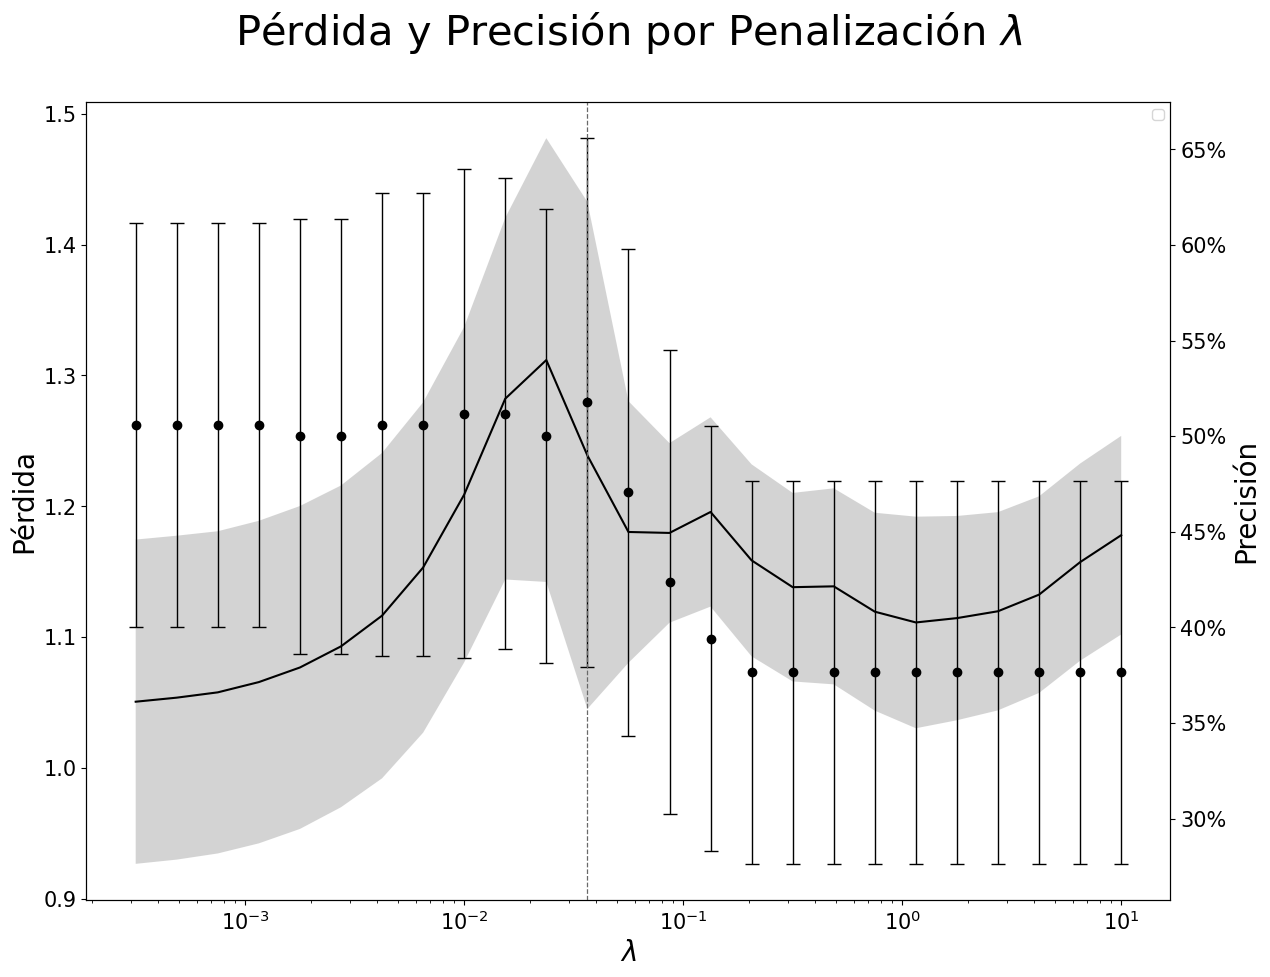

()

In [16]:
plt_lossaccCV(
    df_loss=dict_best_lambdas['stats']['loss'],
    df_acc=dict_best_lambdas['stats']['acc'],
    lambs=dict_best_lambdas['lambdas'],
    folder_name='complete_model/'
    )

### Observe weights $W$ for each penalization value $\lambda$

In [18]:
# get all the W weights per penalization value for ALL the train and validation test
dict_weights_decayment = get_lassoWeights(
    dbb=dbb,
    lambdas=lambdas,
    metric='loss',
    seed=SEED_VALUE
)

progress: |██████████| 100.0% complete


#### Plot weights decay per $Y_{i}$ objective

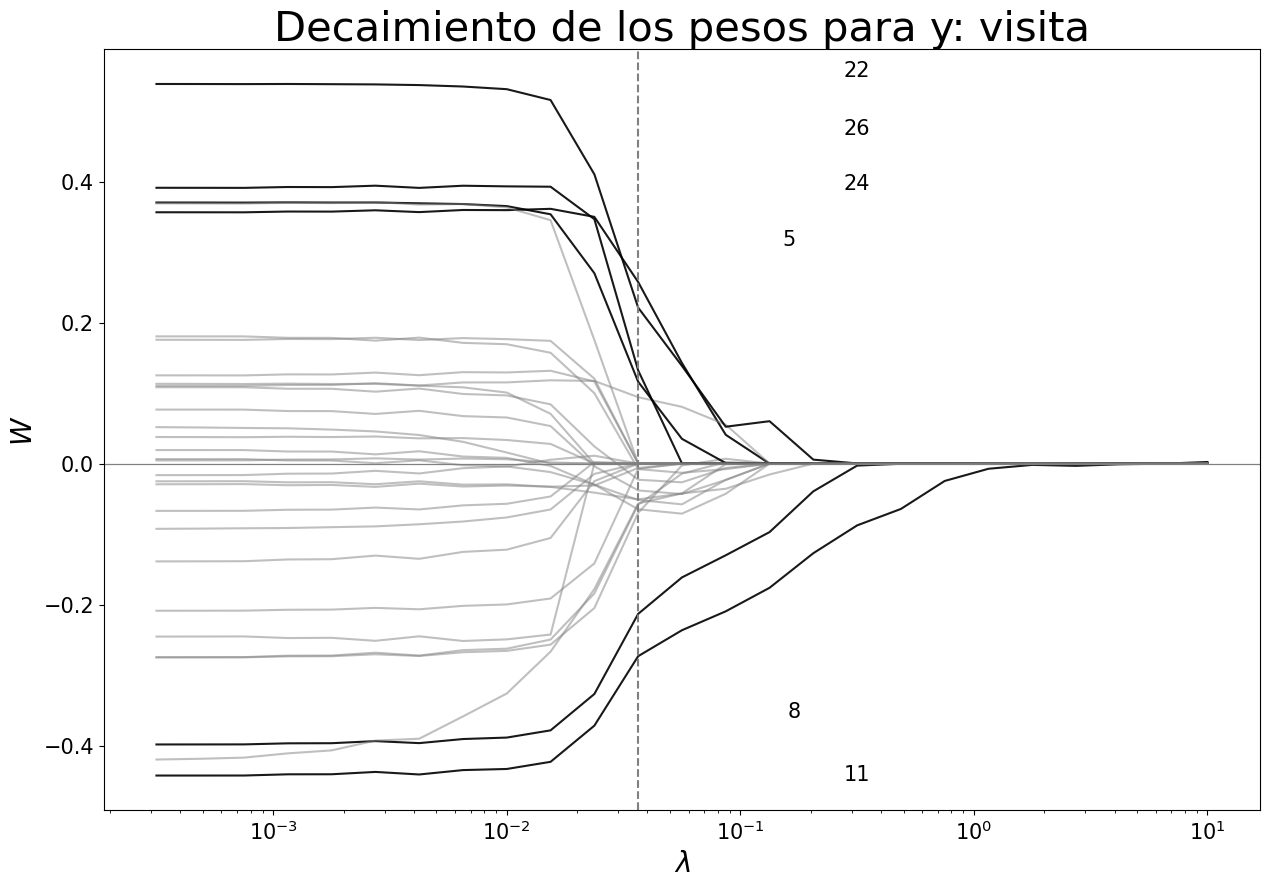

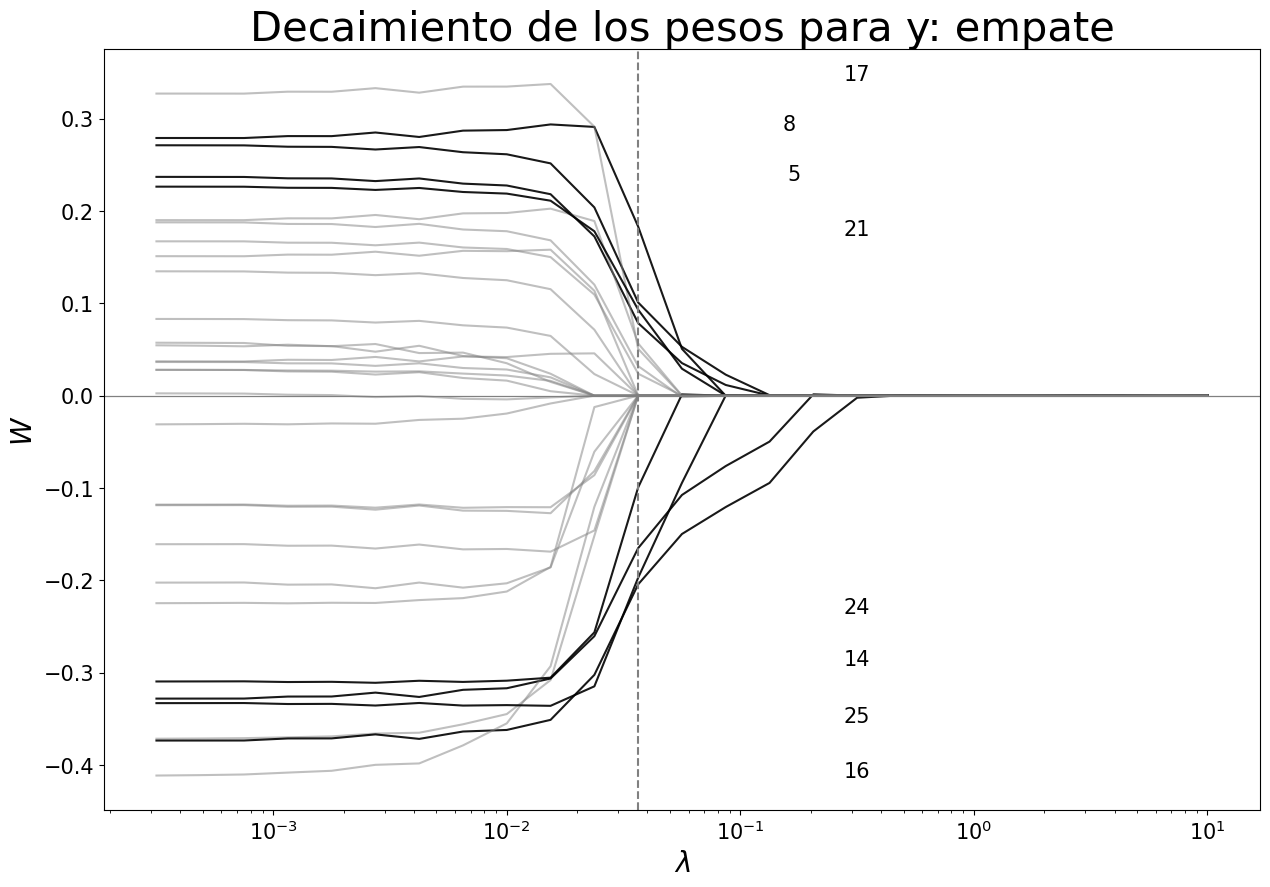

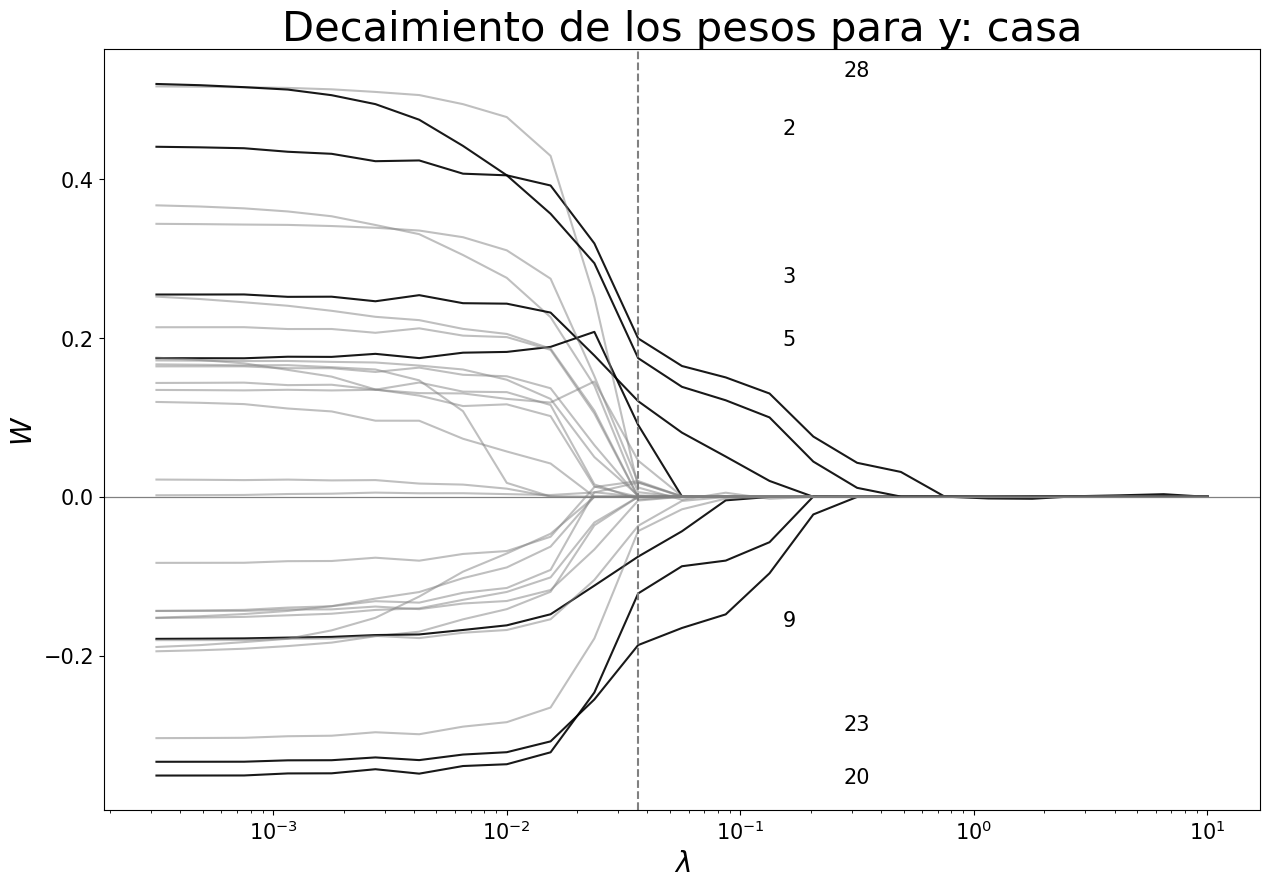

()

In [20]:
pltW_objectiveY(
    dic=dict_weights_decayment,
    lambdas=dict_best_lambdas['stats']['acc']['lambdas'],
    lambda_model=dict_best_lambdas['lambdas']['optimal'],
    threshold_factor=1,
    folder_name='complete_model/'
)

#### Plot weights decayment $W$ per covariable $X_{i}$

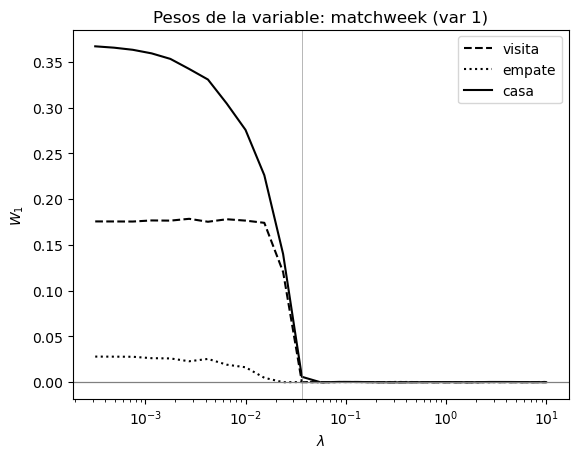

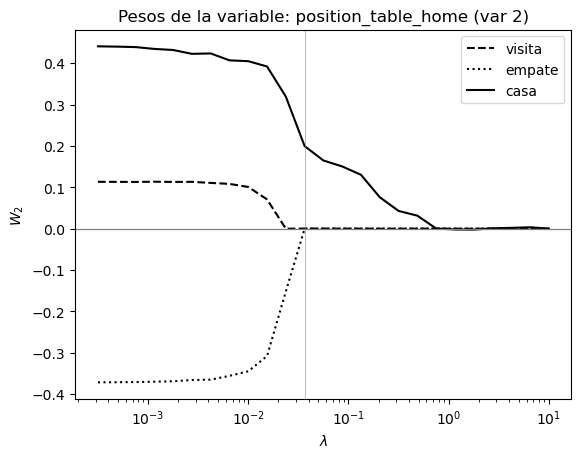

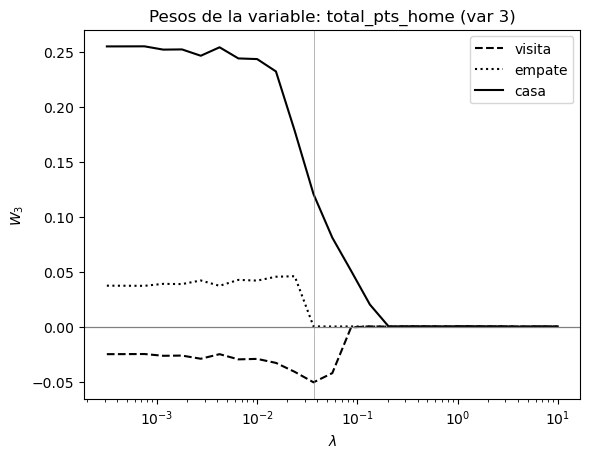

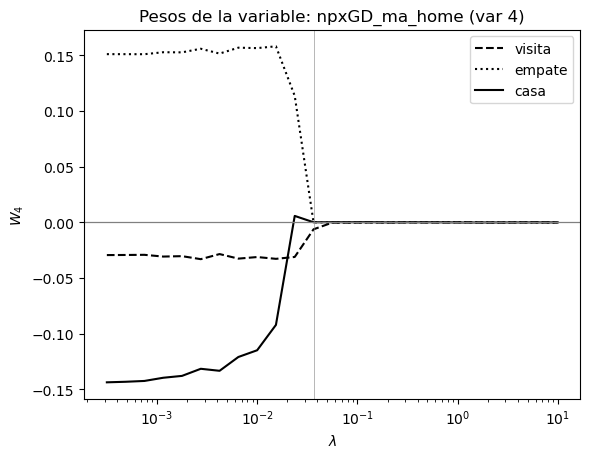

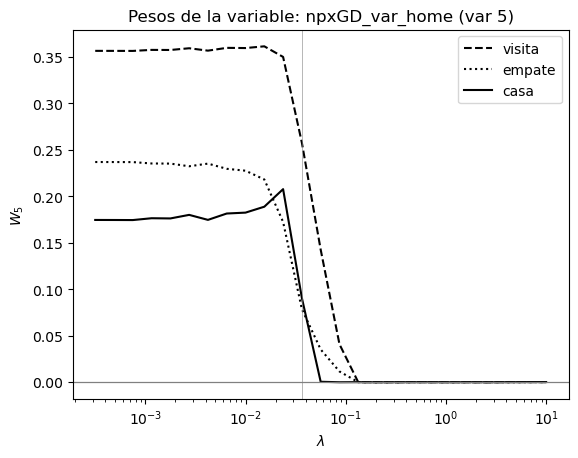

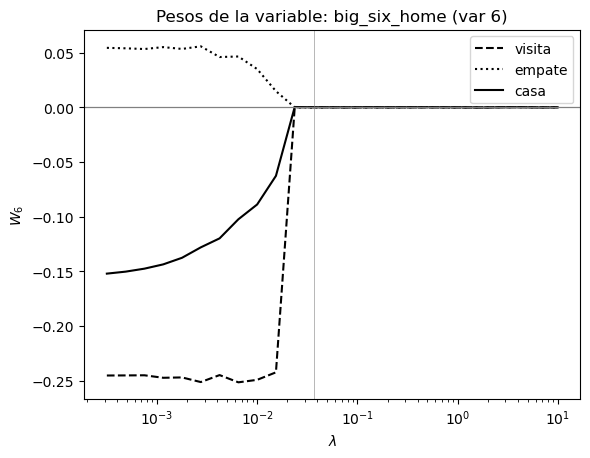

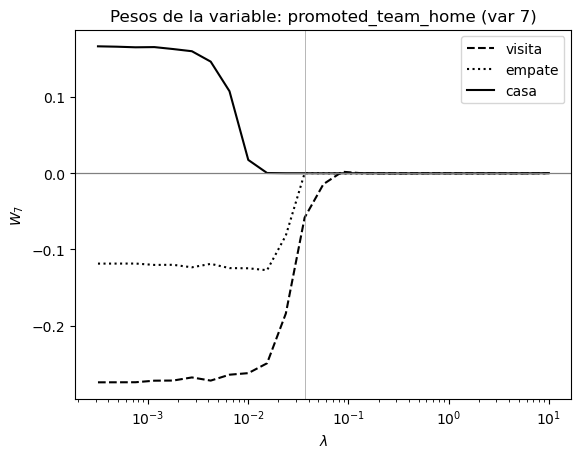

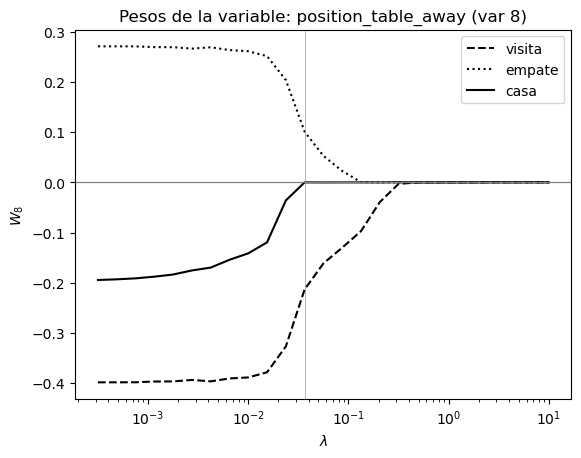

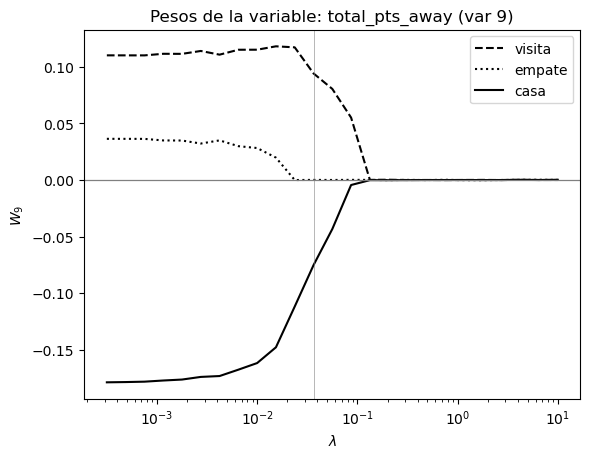

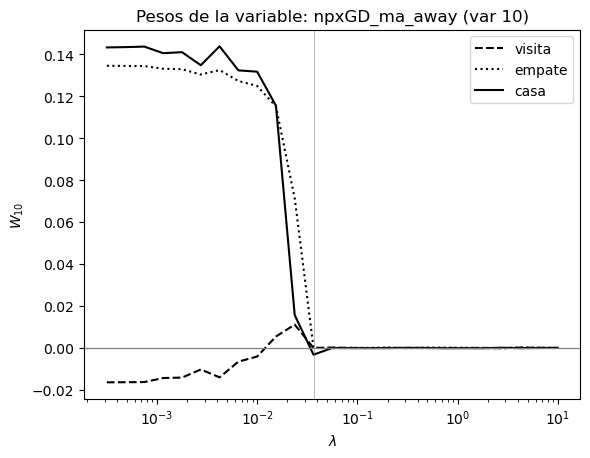

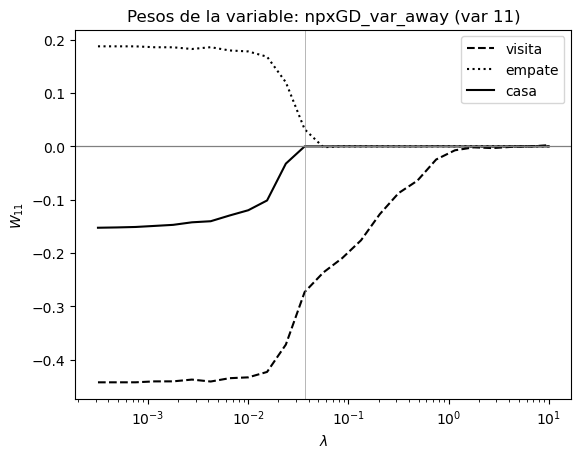

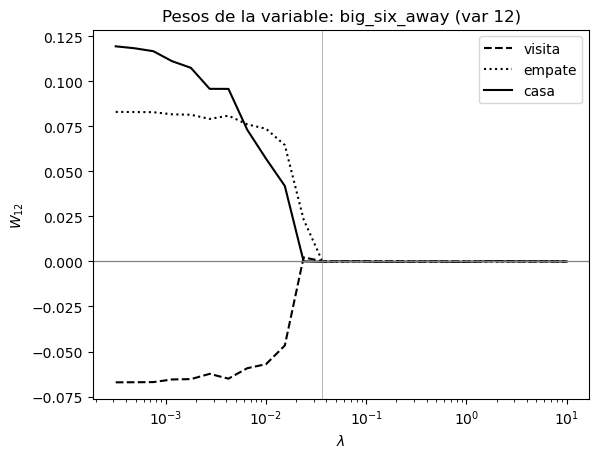

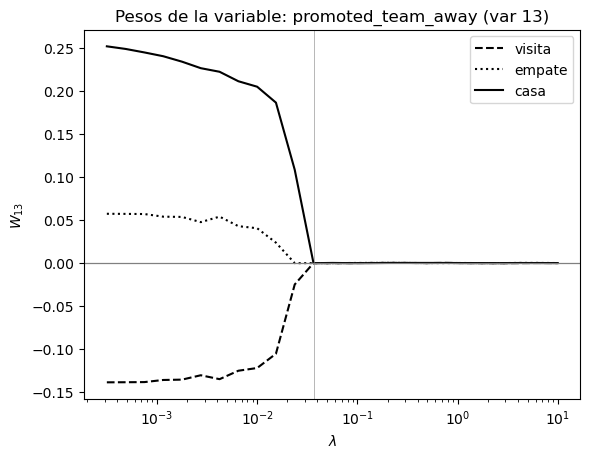

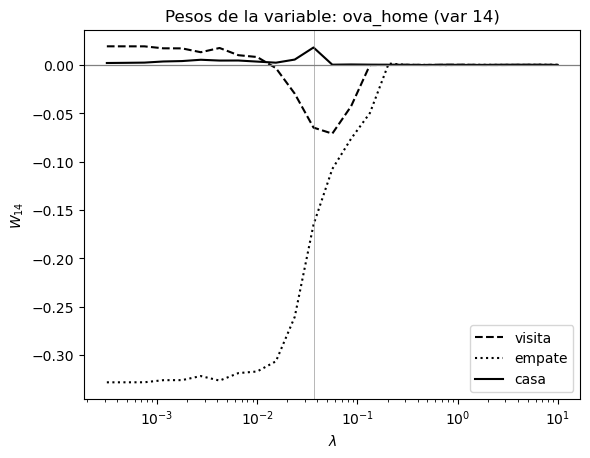

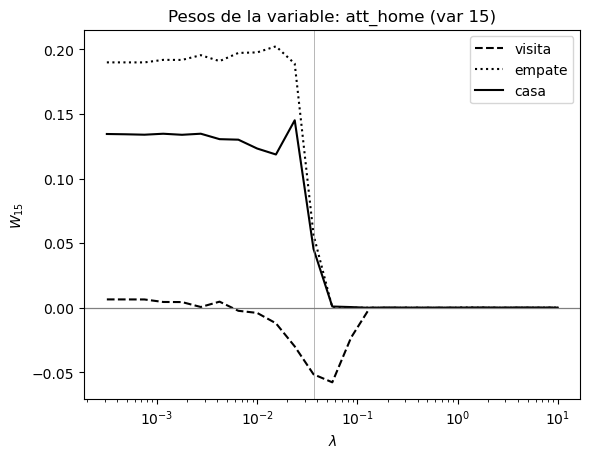

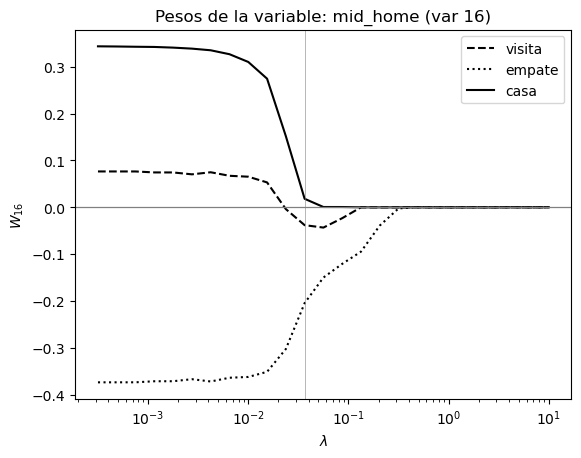

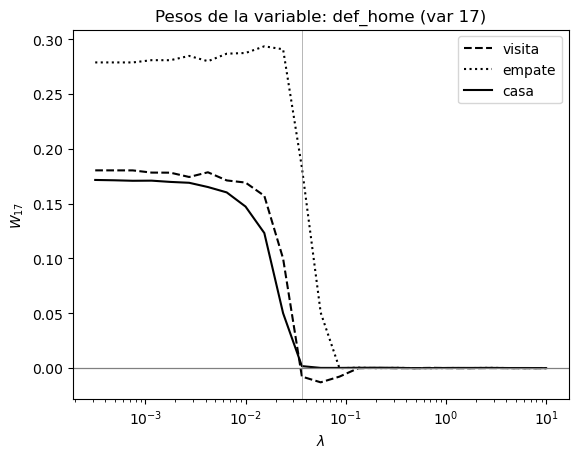

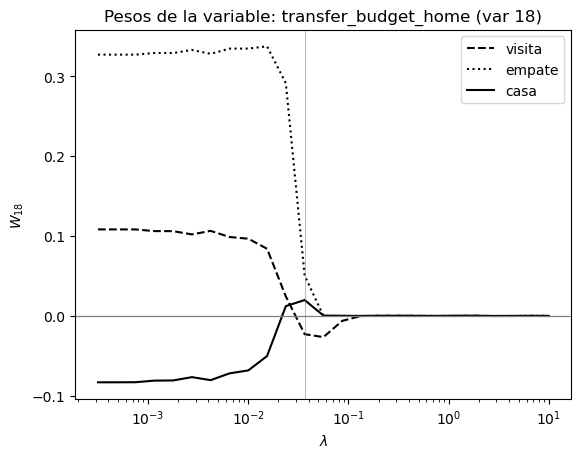

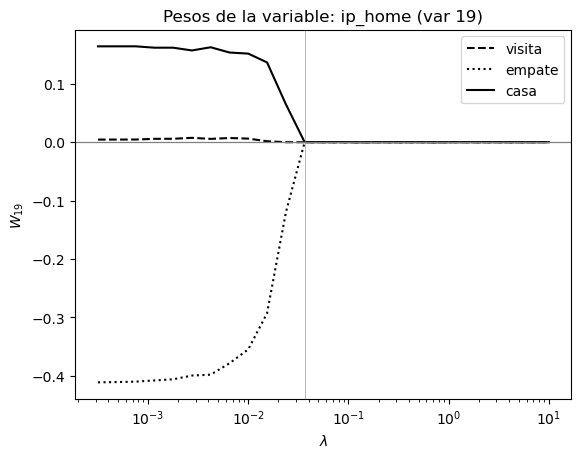

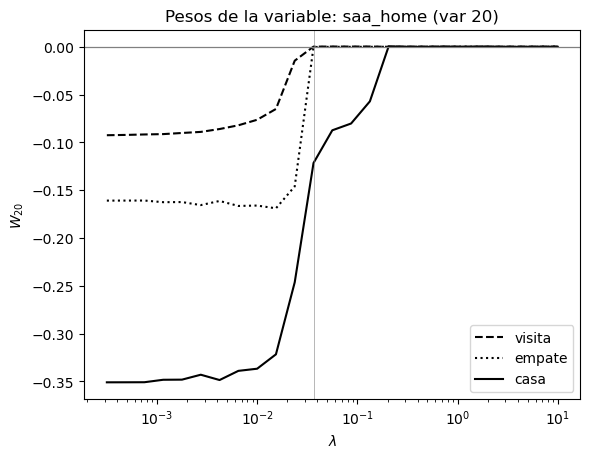

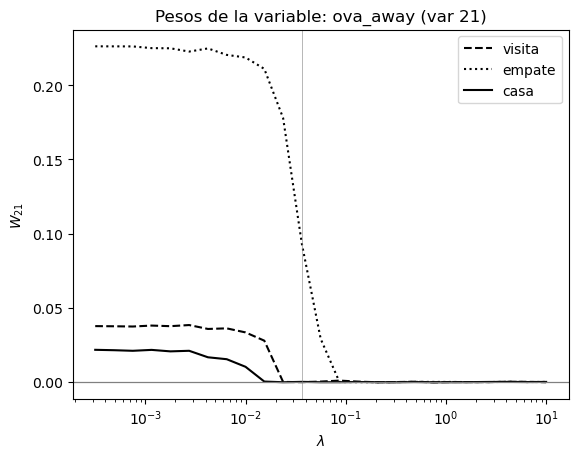

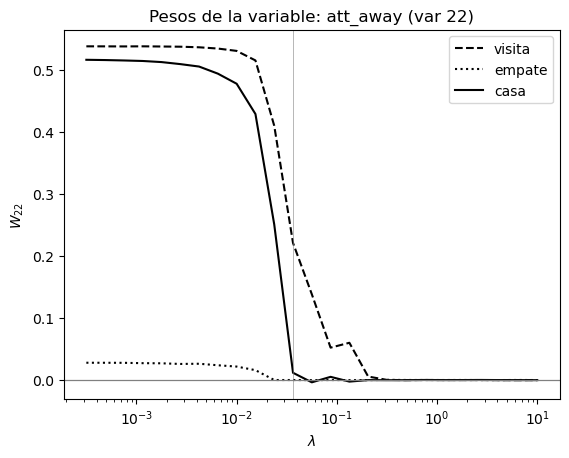

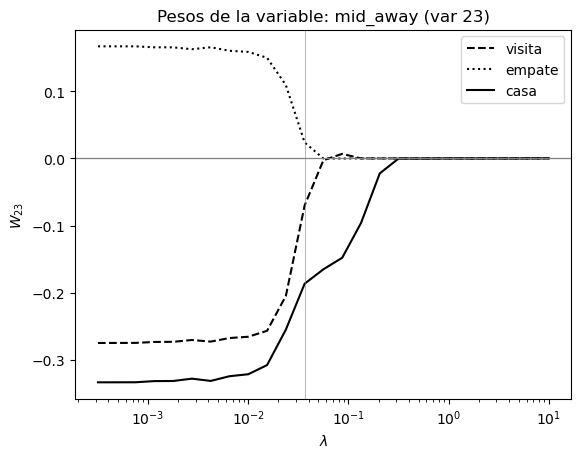

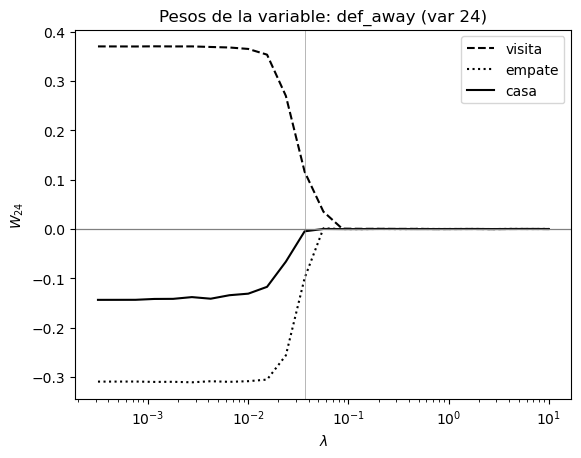

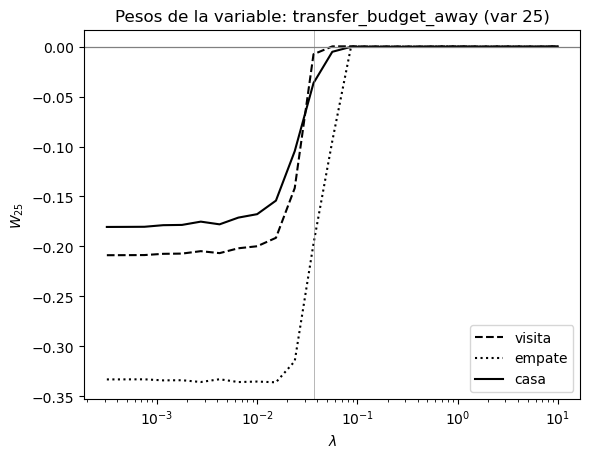

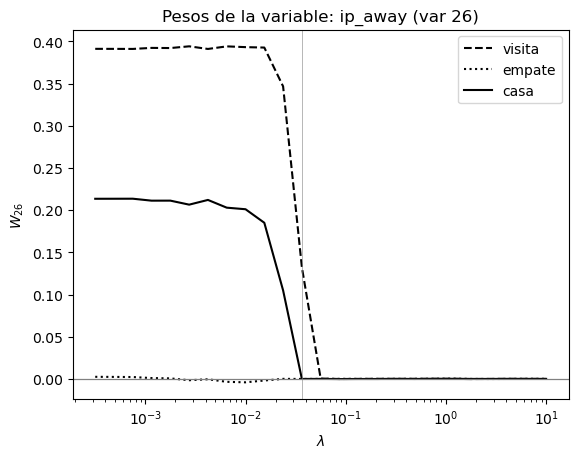

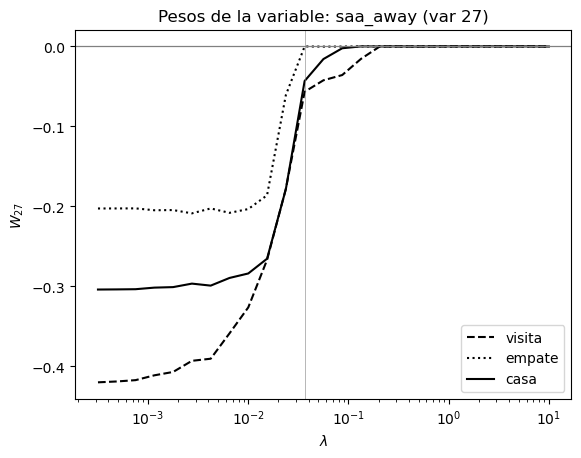

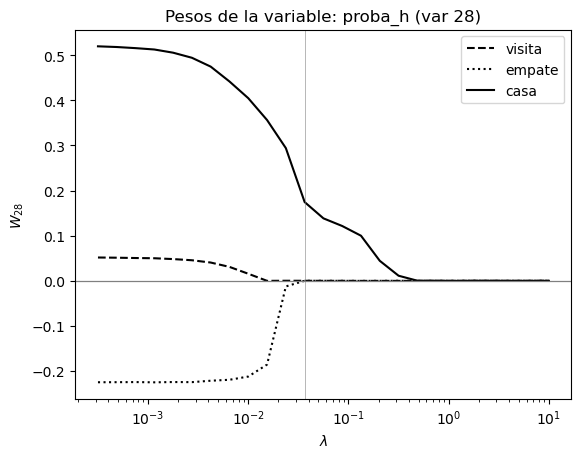

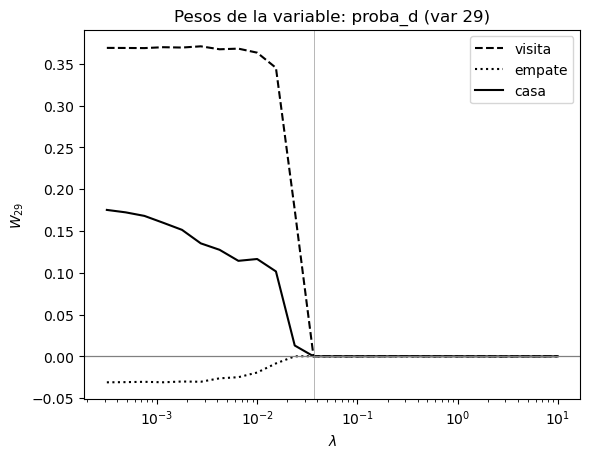

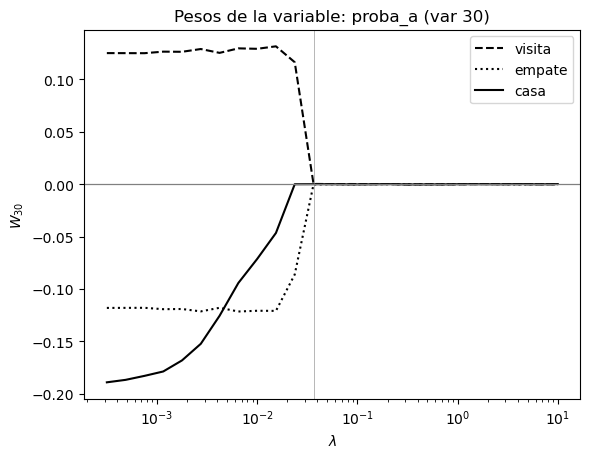

()

In [22]:
pltW_covars(
    dic=dict_weights_decayment,
    lambdas=dict_best_lambdas['stats']['acc']['lambdas'],
    lambda_model=dict_best_lambdas['lambdas']['optimal'],
    vars_names=vars_model,
    folder_name='complete_model/'
)

#### Plot bias $b$

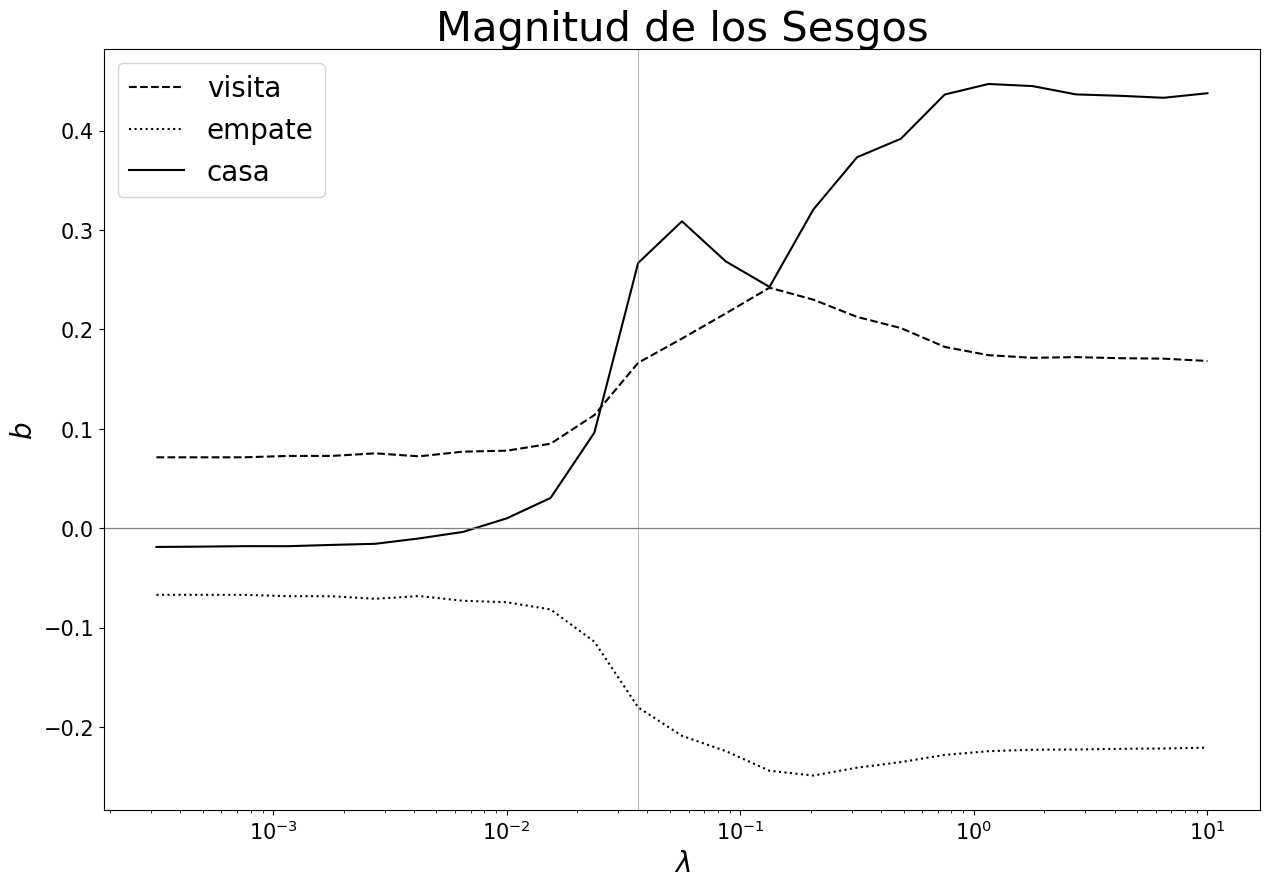

()

In [24]:
plt_bias(
    dic=dict_weights_decayment,
    lambdas=dict_best_lambdas['stats']['acc']['lambdas'],
    lambda_model=dict_best_lambdas['lambdas']['optimal'],
    folder_name='complete_model/'
)

## Final Selection of Variables $X_{i}$

The analysis yield the following:





The following was observed:

<!-- 1. The best **penalization** using the 'loss' (cross entropy) metric but regarding the accuracy of the model were the following:
  - 'optimal': 0.005302611335911987
  - 'sparser_1std': 0.08891593339164641
  
  We used the `optimal` $\lambda_{*}$ instead of the `sparser_1std` $\lambda$ by the fact that, althought that the best accuracy obtained $\lambda_{*}$ the 1 std/confidence interval $\lambda$ also contained that best accuracy, the accuracy drop down more than a 100 base points for both cases.

  Also, the loss _very few times_ went down at increasing $\lambda$ in the TCV, so for the later model, we should use low values of penalization, either for lasso, ridge or elastic net.


---

2. **Power predictor variables**.
  - For _Home_:
    The variables with predictive power were:
    - 1, 4, 9, 14, 16, 25, 28; `matchweek`, `npxGD_ma_home`, `total_pts_away` (negative), `ova_home`, `mid_home` (negative), `transfer_budget_away` (negative), `proba_home`)

  - For _Draw_:
    The variables with predictive power were:
    - 3, 15, 16, 21, 28; `total_pts_home` (negative), `att_home`, `mid_home` (negative), `ova_away` (negative), `proba_h` (negative)

  - For _Away_:
    The variables with predictive power were:
    - 2, 3, 6, 10, 12, 16, 17, 19, 28; `position_table_home`, `total_pts_home` (negative), `big_six_home` (negative), `npxGD_ma_away`, `big_six_away`, `mid_home` (negative), `def_home` (negative), `ip_home` (negative), `proba_h` (negative)


3. **Behaviour of variables along penalization**
Look `Figures_Colab/Lasso_Selection/By_Covars` to see each plot -->

### Get subset dbb

In [28]:
# variables subset
# vars_model_ss = [
#     'npxGD_ma_home',
#     'npxGD_ma_away',
#     'att_home',
#     'att_away'
#   ]

vars_model_ss = [
    'total_pts_home',
    'npxGD_var_home', 'big_six_home',
    'total_pts_away',
    'npxGD_var_away', 'big_six_away',
    'def_home',
    'ip_home',
    'def_away',
    'proba_h'
  ]

# main database (subsetted)
dbb_ss = tidy_bdd(df_r, queries=queries_model, objective_var='result', var=vars_model_ss)

# look data base subsetted
dbb_ss['train']['X']

,total_pts_home,npxGD_var_home,big_six_home,total_pts_away,npxGD_var_away,big_six_away,def_home,ip_home,def_away,proba_h
0,1.190323,0.000000,0,-1.031613,0.000000,0,-0.620432,0.789474,-0.067401,0.366881
1,1.190323,0.000000,1,-0.290968,0.000000,0,1.315178,1.000000,-1.726495,0.816695
2,-1.031613,0.000000,0,-1.031613,0.000000,0,-1.449979,0.473684,-1.173463,0.376331
3,-0.290968,0.000000,0,1.190323,0.000000,1,0.485631,0.789474,1.038662,0.369327
4,-1.031613,0.000000,0,-0.290968,0.000000,0,-0.896948,0.526316,-1.173463,0.584393
...,...,...,...,...,...,...,...,...,...,...
2215,0.633511,1.186842,0,0.691555,0.893377,1,0.696566,0.263158,1.290969,0.258780
2216,1.562218,4.913269,1,-1.746301,1.800093,0,1.885372,0.421053,-1.383844,0.924572
2217,-0.411285,1.741526,0,2.607013,1.583107,1,0.102163,0.105263,2.479775,0.178459
2218,-0.121064,2.323610,0,0.169157,1.651204,0,-0.195038,0.157895,-0.492240,0.487238


### Get best penalization value for subset model

In [30]:
# get best lambda's
dict_best_lambdas_subset = get_lambdaLassoTCV(
    dbb=dbb_ss,
    lambdas=lambdas,
    nsplit_cv=n_cv,                 # number of matchweeks to evaluate
    ntest_cv=n_games_per_matchweek, # number of observations in test set in the tcv
    metric='loss',                  # EarlyStopping metric
    seed=SEED_VALUE
)


temporal CV of 17 folds




training model no.1 of 25
2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 

training model no.6 of 25
2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 

training model no.11 of 25
2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 

In [31]:
# look best lambdas
dict_best_lambdas_subset['lambdas']

{'optimal': 0.00031622776601683794, 'sparser_1std': 0.31622776601683794}

#### Accuracy and Loss graphs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


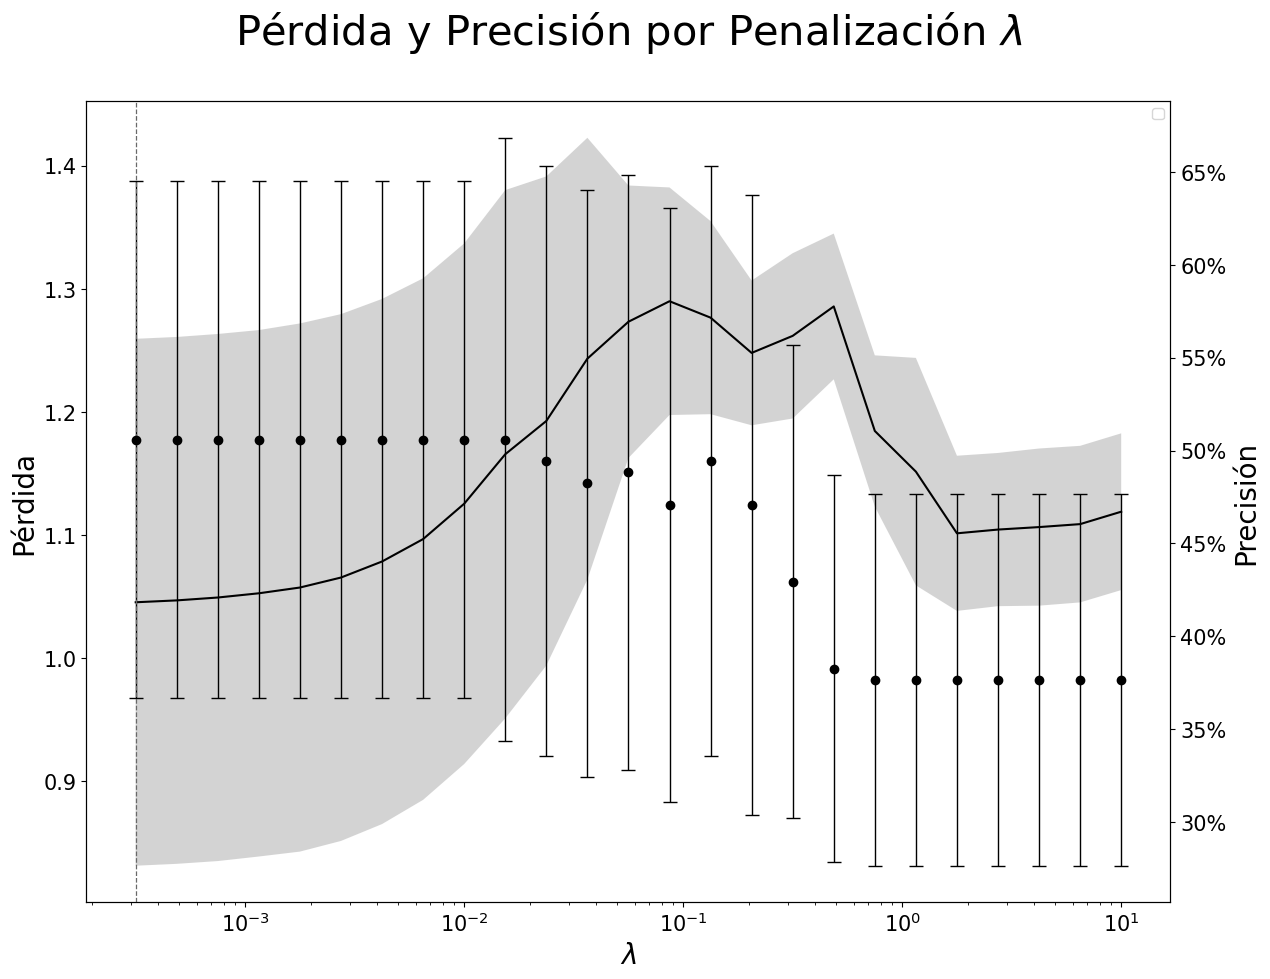

()

In [33]:
plt_lossaccCV(
    df_loss=dict_best_lambdas_subset['stats']['loss'],
    df_acc=dict_best_lambdas_subset['stats']['acc'],
    lambs=dict_best_lambdas_subset['lambdas'],
    folder_name='subset_model/'
    )

### Observe weights $W$ for each penalization value $\lambda$ of subsetted model

In [35]:
# get all the W weights per penalization value for ALL the train and validation test
dict_weights_decayment_subset = get_lassoWeights(
    dbb=dbb_ss,
    lambdas=lambdas,
    metric='loss',
    seed=SEED_VALUE
)

progress: |██████████| 100.0% complete


#### Plot weights decay per $Y_{i}$ objective

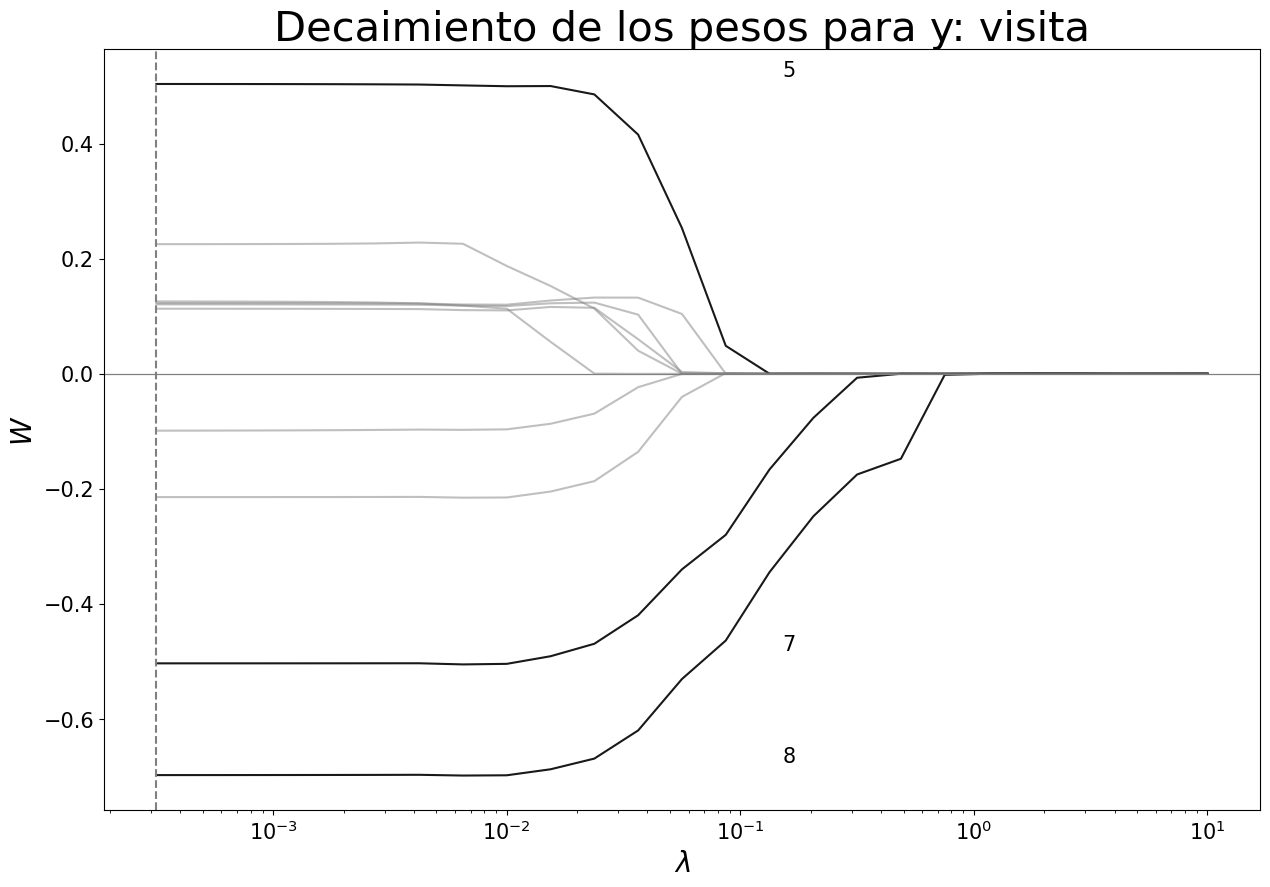

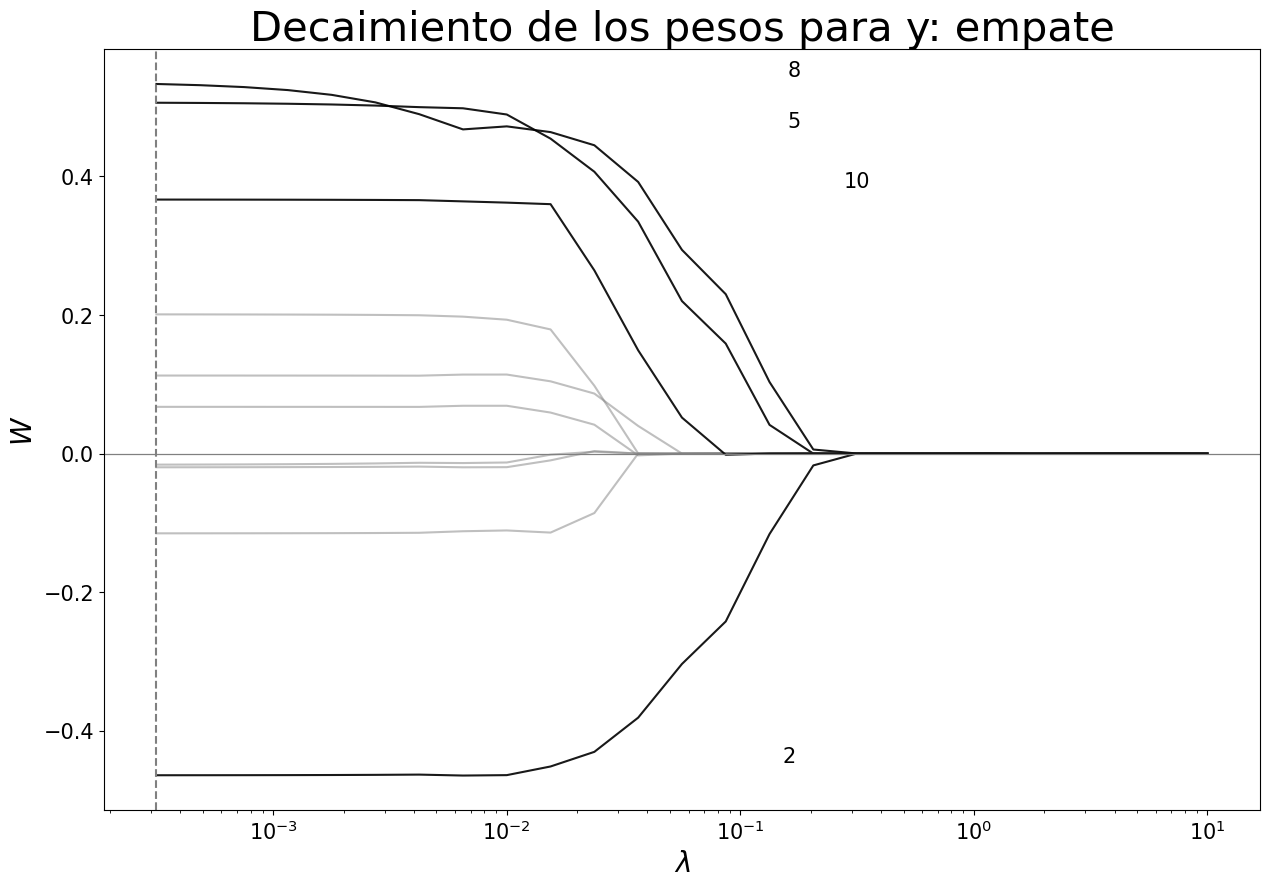

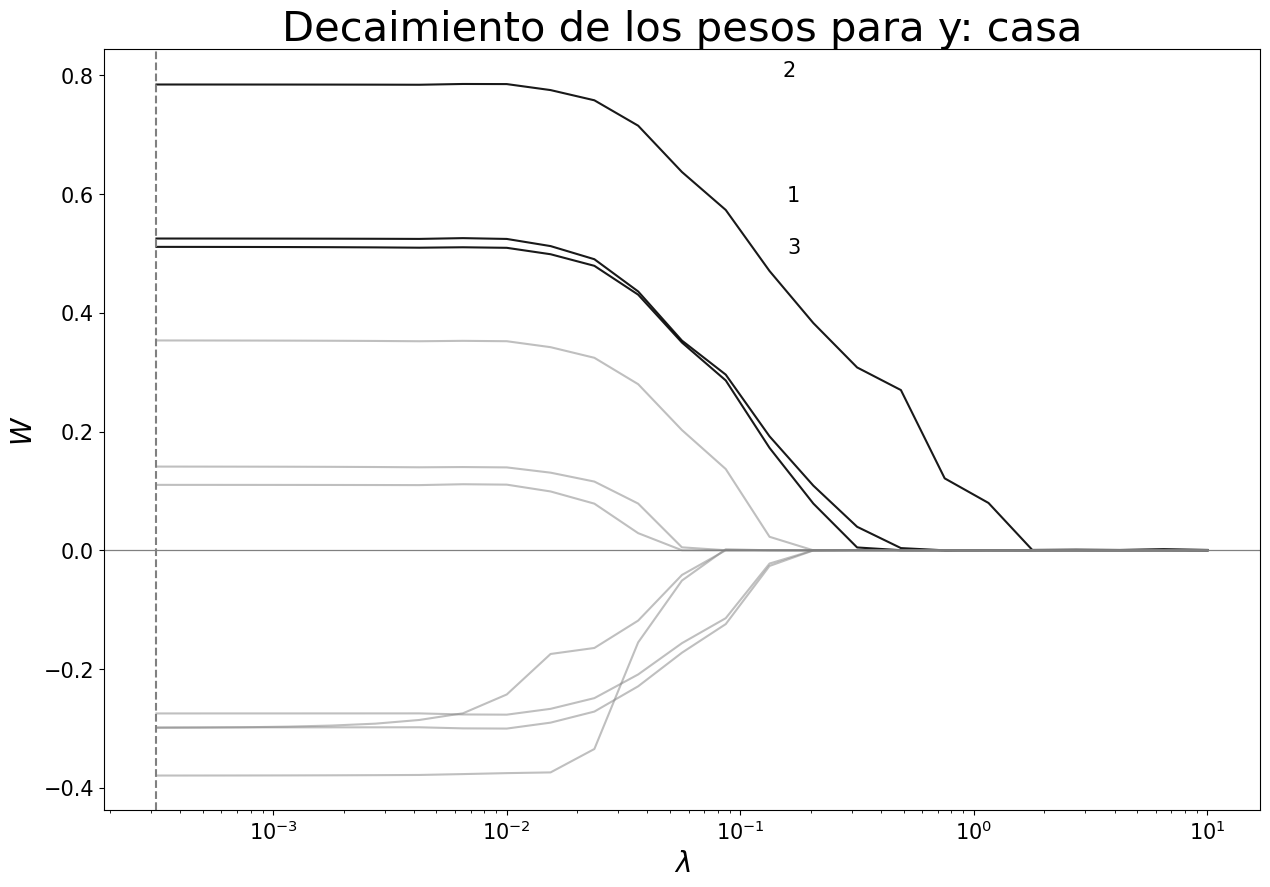

()

In [37]:
pltW_objectiveY(
    dic=dict_weights_decayment_subset,
    lambdas=dict_best_lambdas_subset['stats']['acc']['lambdas'],
    lambda_model=dict_best_lambdas_subset['lambdas']['optimal'],
    threshold_factor=1,
    folder_name='subset_model/'
)

#### Plot weights decayment $W$ per covariable $X_{i}$

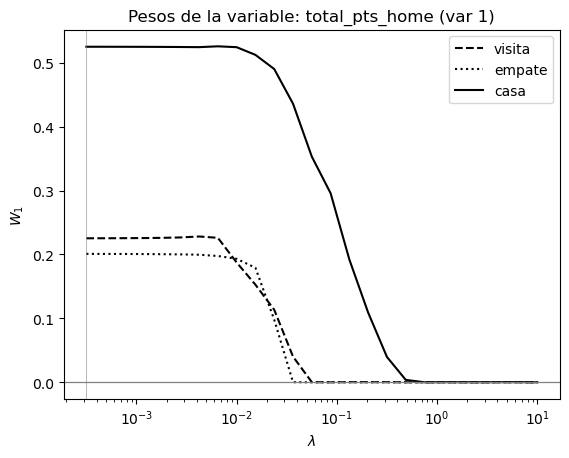

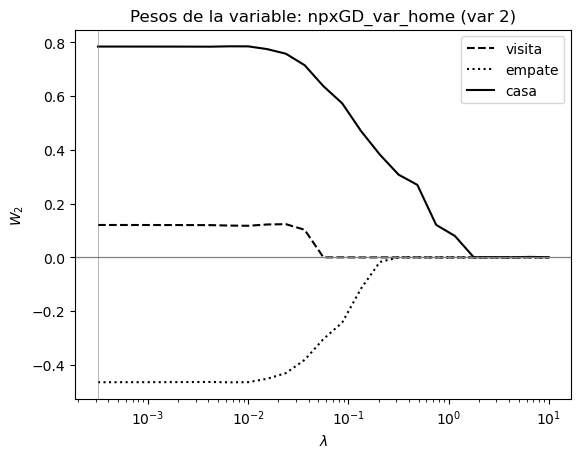

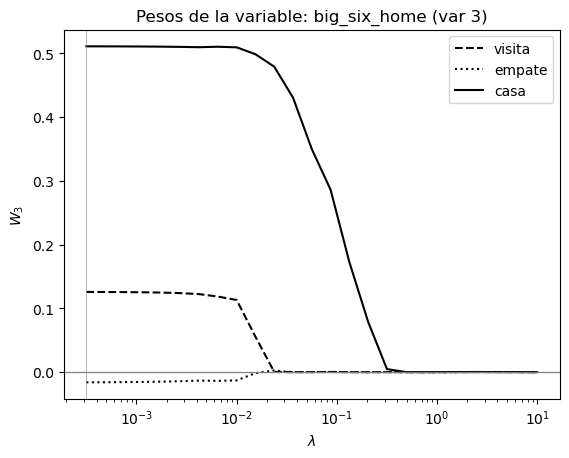

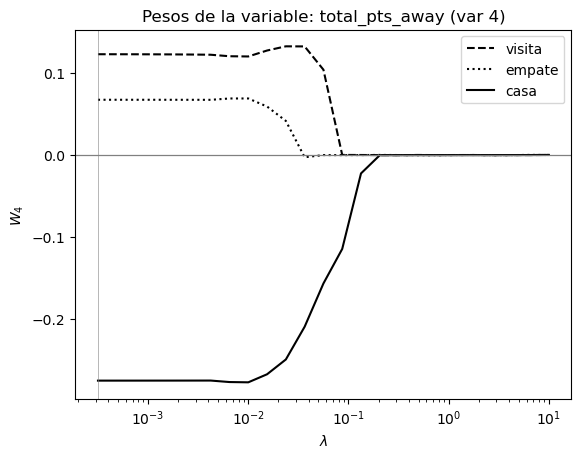

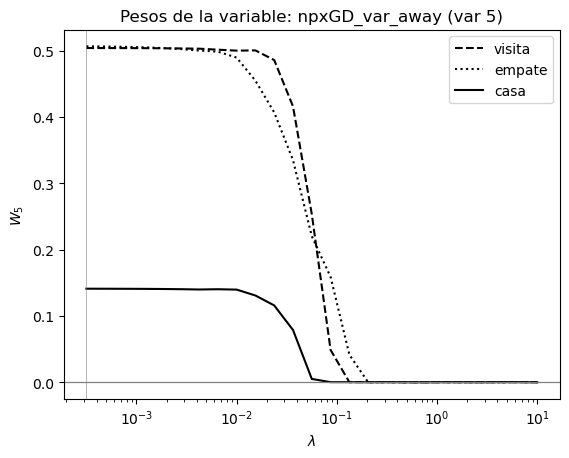

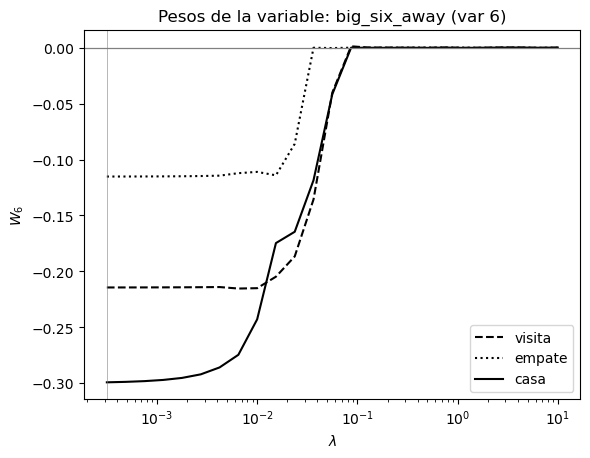

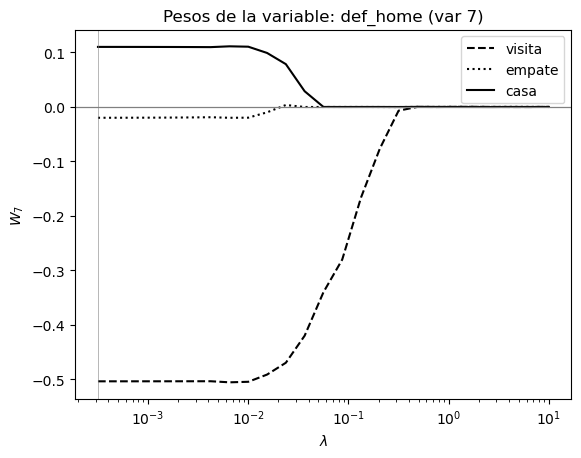

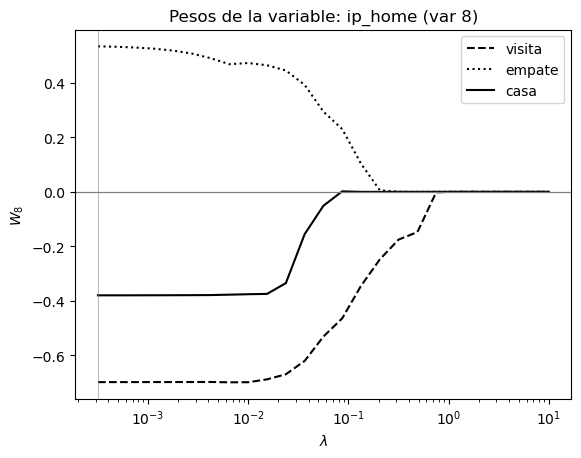

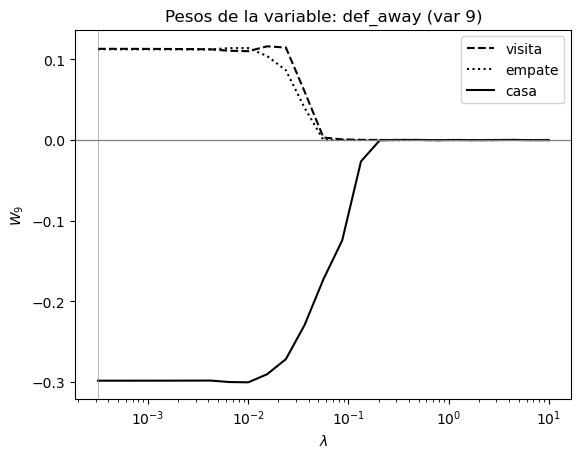

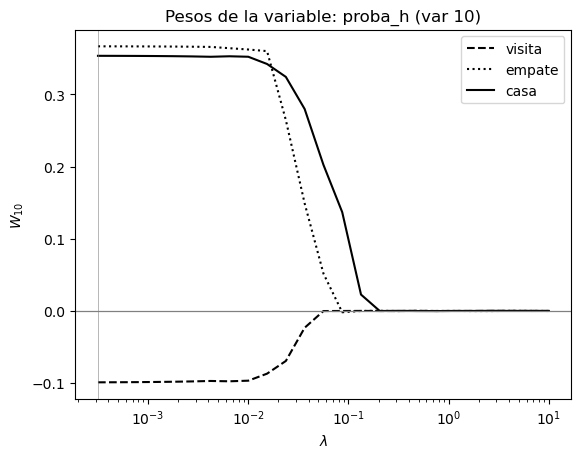

()

In [39]:
pltW_covars(
    dic=dict_weights_decayment_subset,
    lambdas=dict_best_lambdas_subset['stats']['acc']['lambdas'],
    lambda_model=dict_best_lambdas_subset['lambdas']['optimal'],
    vars_names=vars_model_ss,
    folder_name='subset_model/'
)

#### Plot bias $b$

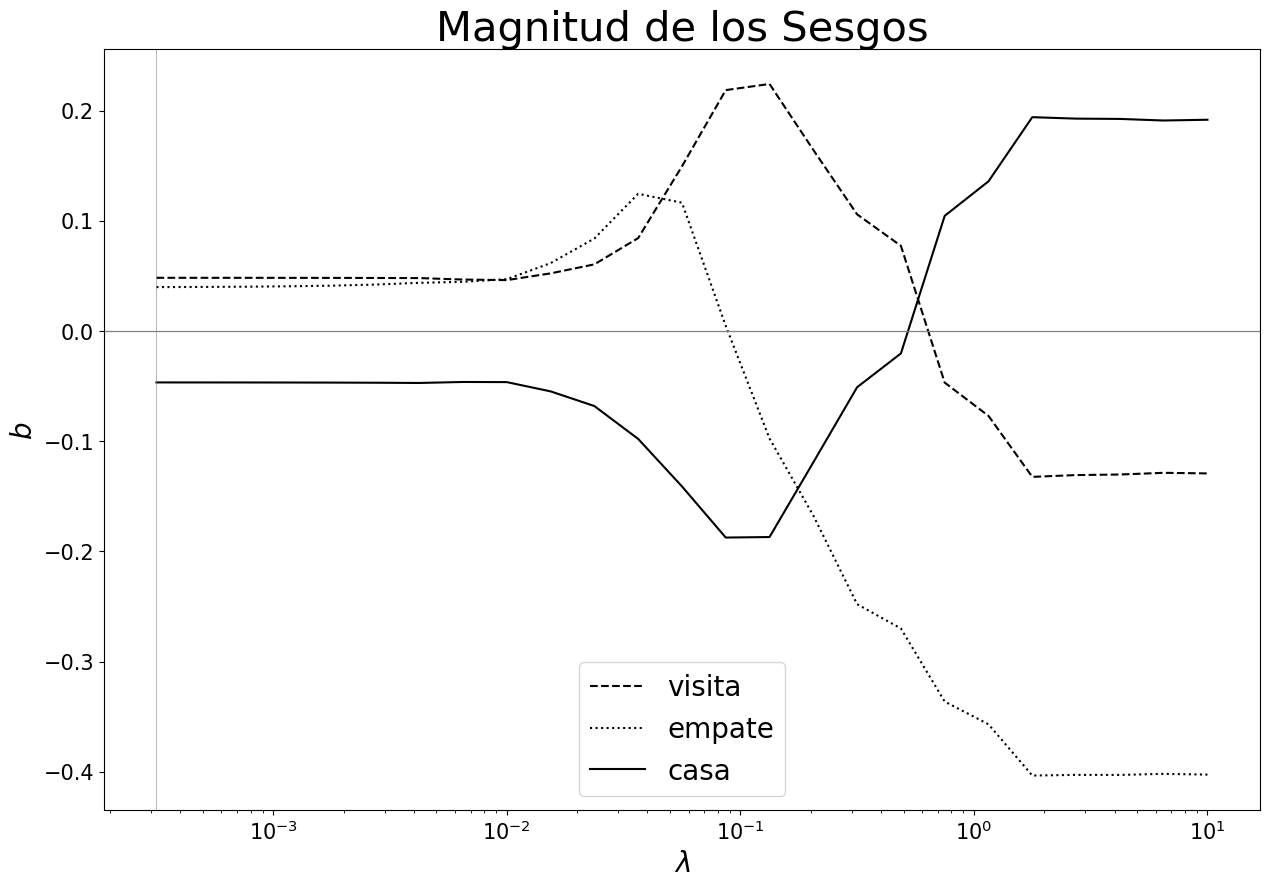

()

In [41]:
plt_bias(
    dic=dict_weights_decayment_subset,
    lambdas=dict_best_lambdas_subset['stats']['acc']['lambdas'],
    lambda_model=dict_best_lambdas_subset['lambdas']['optimal'],
    folder_name='subset_model/'
)

### Best variables subsets
Train a shallow neural network (multinomial regression) with three variables sets:

1. Complete Set. All the variables in the database
2. Semi-complete Set. Get rid of logical colineal variables; for example, get rid from `proba_d` if we have `proba_h` & `proba_a`. Also get rid of non-sense variables.
3. Subset. From the Lasso Analysis, get an intuitive subset.


For all the models the comparisson will involve the penalization for their best performance, for each one.


In [43]:
# semi
vars_model_semi = [
    'matchweek', 'total_pts_home',
    'npxGD_ma_home', 'npxGD_var_home', 'big_six_home',
    'promoted_team_home',
    'total_pts_away',
    'npxGD_ma_away', 'npxGD_var_away', 'big_six_away',
    'promoted_team_away', 'att_home', 'def_home',
    'transfer_budget_home', 'ip_home',
    'att_away', 'def_away',
    'transfer_budget_away', 'ip_away',
    'proba_h', 'proba_a'
  ]

# main database (subsetted)
dbb_semi = tidy_bdd(df_r, queries=queries_model, objective_var='result', var=vars_model_semi)

# look data base subsetted
dbb_semi['train']['X']

,matchweek,total_pts_home,npxGD_ma_home,npxGD_var_home,big_six_home,promoted_team_home,total_pts_away,npxGD_ma_away,npxGD_var_away,big_six_away,...,att_home,def_home,transfer_budget_home,ip_home,att_away,def_away,transfer_budget_away,ip_away,proba_h,proba_a
0,0.0,1.190323,0.486406,0.000000,0,0,-1.031613,-0.514947,0.000000,0,...,-1.363602,-0.620432,-0.966504,0.789474,0.034964,-0.067401,-0.827160,0.789474,0.366881,0.338953
1,0.0,1.190323,1.758819,0.000000,1,0,-0.290968,0.665027,0.000000,0,...,0.734247,1.315178,0.496609,1.000000,-1.829791,-1.726495,-1.088430,0.473684,0.816695,0.053671
2,0.0,-1.031613,-1.395959,0.000000,0,0,-1.031613,0.074870,0.000000,0,...,-1.596696,-1.449979,-1.175520,0.473684,-0.431225,-1.173463,-1.088430,0.631579,0.376331,0.335369
3,0.0,-0.290968,-0.665027,0.000000,0,0,1.190323,1.395959,0.000000,1,...,0.034964,0.485631,-0.966504,0.789474,0.268058,1.038662,-0.374291,0.894737,0.369327,0.348372
4,0.0,-1.031613,0.220560,0.000000,0,0,-0.290968,-0.069641,0.000000,0,...,-0.431225,-0.896948,-1.071012,0.526316,-1.829791,-1.173463,-1.105848,0.684211,0.584393,0.174384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,1.0,0.633511,0.669408,1.186842,0,0,0.691555,0.871207,0.893377,1,...,0.420144,0.696566,0.002227,0.263158,1.130247,1.290969,1.962229,0.315789,0.258780,0.474641
2216,1.0,1.562218,1.654646,4.913269,1,0,-1.746301,-1.225615,1.800093,0,...,2.077051,1.885372,1.962229,0.421053,-0.763361,-1.383844,-0.710501,0.000000,0.924572,0.023453
2217,1.0,-0.411285,-0.422394,1.741526,0,0,2.607013,0.515030,1.583107,1,...,-0.763361,0.102163,-0.692682,0.105263,2.077051,2.479775,1.962229,0.473684,0.178459,0.612181
2218,1.0,-0.121064,0.181966,2.323610,0,0,0.169157,-0.507789,1.651204,0,...,-0.526660,-0.195038,-0.354137,0.157895,-1.236763,-0.492240,-0.959955,0.000000,0.487238,0.247958


In [44]:
# init vals
names_y = ['visita', 'empate', 'local']

# train subsetted model & complete model
shallow_nn_subset = build_model(
    dbb=dbb_ss,
    lambda_val=dict_best_lambdas_subset['lambdas']['optimal'],
    metric_stop='loss',
    seed=SEED_VALUE,
    return_model=True
)

shallow_nn_semicomplete = build_model(
    dbb=dbb_semi,
    lambda_val=dict_best_lambdas['lambdas']['optimal'],
    metric_stop='loss',
    seed=SEED_VALUE,
    return_model=True
)

shallow_nn_complete = build_model(
    dbb=dbb,
    lambda_val=dict_best_lambdas['lambdas']['optimal'],
    metric_stop='loss',
    seed=SEED_VALUE,
    return_model=True
)

# get weights in dataframe
dict_shallow_weights_subset = shallow_nn_subset.get_weights()
df_shallow_weights = (
    pd.concat((
        pd.DataFrame(dict_shallow_weights_subset[1].reshape((1, -1)), index=['intercept'], columns=names_y),
        pd.DataFrame(dict_shallow_weights_subset[0], index=vars_model_ss, columns=names_y)
    ))
)

dict_shallow_weights_semi = shallow_nn_semicomplete.get_weights()
df_shallow_weights_semi = (
    pd.concat((
        pd.DataFrame(dict_shallow_weights_semi[1].reshape((1, -1)), index=['intercept'], columns=names_y),
        pd.DataFrame(dict_shallow_weights_semi[0], index=vars_model_semi, columns=names_y)
    ))
)



In [45]:
# look frame
df_shallow_weights

,visita,empate,local
intercept,0.048291,0.039846,-0.046673
total_pts_home,0.225292,0.200865,0.525160
npxGD_var_home,0.120641,-0.464440,0.784621
big_six_home,0.125767,-0.016044,0.511102
total_pts_away,0.122861,0.067381,-0.274886
npxGD_var_away,0.503803,0.506383,0.140965
big_six_away,-0.214410,-0.115215,-0.299242
def_home,-0.503403,-0.019875,0.110165
ip_home,-0.697662,0.533460,-0.379516
def_away,0.113117,0.112568,-0.298367


In [46]:
# look frame
df_shallow_weights_semi

,visita,empate,local
intercept,-0.251645,-0.173644,0.178949
matchweek,0.000049,-0.000015,0.454548
total_pts_home,-0.000174,-0.148235,0.381710
npxGD_ma_home,-0.000175,-0.000058,0.180473
npxGD_var_home,-0.000006,-0.047966,-0.035290
big_six_home,0.055120,0.094076,-0.000180
promoted_team_home,0.000221,-0.000198,-0.000048
total_pts_away,-0.181194,0.000101,-0.046910
npxGD_ma_away,-0.312080,0.141125,-0.395304
npxGD_var_away,-0.000071,-0.023264,-0.060312


In [47]:
# accuracy & loss
loss_acc_subset = shallow_nn_subset.evaluate(x=dbb_ss['validation']['X'], y=dbb_ss['validation']['y'], verbose=0)
loss_acc_semi = shallow_nn_semicomplete.evaluate(x=dbb_semi['validation']['X'], y=dbb_semi['validation']['y'], verbose=0)
loss_acc_complete = shallow_nn_complete.evaluate(x=dbb['validation']['X'], y=dbb['validation']['y'], verbose=0)

# print
print(f"Subset Model \nLoss:{np.round(loss_acc_subset[0], 2)}\t Acc:{np.round(100*loss_acc_subset[1], 2)}%")
print(f"\nSemi Complete Model\nLoss:{np.round(loss_acc_semi[0], 2)}\t Acc:{np.round(100*loss_acc_semi[1], 2)}%")
print(f"\nComplete Model\nLoss:{np.round(loss_acc_complete[0], 2)}\t Acc:{np.round(100*loss_acc_complete[1], 2)}%")

Subset Model 
Loss:1.06	 Acc:49.41%

Semi Complete Model
Loss:1.25	 Acc:46.47%

Complete Model
Loss:1.19	 Acc:50.0%


# Main Models

The variables to use are the ones selected in the Lasso Subset Analysis, i.e. **all**.



## Train Models

The following models are hyper-trained using RandomSearch from keras:
1. Elastic Net
2. Lasso
3. Ridge
4. Dropout
5. Batch Normalization

### Elastic Net

In [51]:
# save each model of the random search
# generate figure folder
folder_results = "Results/Models_NN_Search"
if not os.path.exists(folder_results):
  os.makedirs(folder_results)

# Model 1: Funnel Architecture, Elastic Net #
tuner_en = kt.RandomSearch(
    hypermodel=build_model_elastic,
    objective='val_loss',
    max_trials=50,
    seed=SEED_VALUE,
    overwrite=True,
    directory=folder_results,
    project_name='elastic_net'
)

X_train = dbb['train']['X'].astype('float32')
y_train = dbb['train']['y'].astype('float32')
X_val   = dbb['validation']['X'].astype('float32')
y_val   = dbb['validation']['y'].astype('float32')

# start search
tuner_en.search(
    X_train, y_train,
    epochs=20,
    validation_data=(
        X_val, y_val
    )
)


Trial 50 Complete [00h 00m 07s]
val_loss: 2.243281364440918

Best val_loss So Far: 1.0516923666000366
Total elapsed time: 00h 07m 01s


In [52]:
tuner_en.results_summary(num_trials=1)

Results summary
Results in Results/Models_NN_Search/elastic_net
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 27 summary
Hyperparameters:
elastic_lambda_l1: 0.0025634672504614214
elastic_lambda_l2: 0.005592871016807845
elastic_lambda_l3: 0.009255349125266087
elastic_lambda_l4: 0.001531045473438731
elastic_alpha_l1: 0.0063262863071530395
elastic_alpha_l2: 0.20185909792686907
elastic_alpha_l3: 0.10953449765007528
elastic_alpha_l4: 0.14123706395420554
units_l1: 29
units_l2: 33
units_l3: 21
lr: 0.01
Score: 1.0516923666000366


### Lasso Penalization

In [54]:
# Model 2: Funnel Architecture, Lasso Penalization #
tuner_lasso = kt.RandomSearch(
    hypermodel=build_model_lasso,
    objective='val_loss',
    max_trials=50,
    seed=SEED_VALUE,
    overwrite=True,
    directory=folder_results,
    project_name='lasso'
)

X_train = dbb['train']['X'].astype('float32')
y_train = dbb['train']['y'].astype('float32')
X_val   = dbb['validation']['X'].astype('float32')
y_val   = dbb['validation']['y'].astype('float32')

# start search
tuner_lasso.search(
    X_train, y_train,
    epochs=20,
    validation_data=(
        X_val, y_val
    )
)

Trial 50 Complete [00h 00m 08s]
val_loss: 1.2000007629394531

Best val_loss So Far: 1.0577365159988403
Total elapsed time: 00h 07m 01s


In [55]:
tuner_lasso.results_summary(num_trials=1)

Results summary
Results in Results/Models_NN_Search/lasso
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 41 summary
Hyperparameters:
elastic_lambda_l1: 0.0001626302344408151
elastic_lambda_l2: 0.0020984050694760037
elastic_lambda_l3: 0.0011843915267357454
elastic_lambda_l4: 0.001498246933146635
units_l1: 29
units_l2: 33
units_l3: 21
lr: 0.01
Score: 1.0577365159988403


### Ridge Penalization

In [57]:
# Model 3: Funnel Architecture, Ridge Penalization #
tuner_ridge = kt.RandomSearch(
    hypermodel=build_model_ridge,
    objective='val_loss',
    max_trials=50,
    seed=SEED_VALUE,
    overwrite=True,
    directory=folder_results,
    project_name='ridge'
)

X_train = dbb['train']['X'].astype('float32')
y_train = dbb['train']['y'].astype('float32')
X_val   = dbb['validation']['X'].astype('float32')
y_val   = dbb['validation']['y'].astype('float32')

# start search
tuner_ridge.search(
    X_train, y_train,
    epochs=20,
    validation_data=(
        X_val, y_val
    )
)

Trial 50 Complete [00h 00m 09s]
val_loss: 1.1254812479019165

Best val_loss So Far: 1.039493441581726
Total elapsed time: 00h 07m 25s


In [58]:
tuner_ridge.results_summary(num_trials=1)

Results summary
Results in Results/Models_NN_Search/ridge
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 07 summary
Hyperparameters:
elastic_lambda_l1: 0.004813966796070522
elastic_lambda_l2: 0.004205965593155923
elastic_lambda_l3: 0.0008010083778848189
elastic_lambda_l4: 0.0008404581930437964
units_l1: 37
units_l2: 37
units_l3: 41
lr: 0.01
Score: 1.039493441581726


### Dropout

In [60]:
# Model 4: Funnel Architecture, Dropout #
tuner_do = kt.RandomSearch(
    hypermodel=build_model_dropout,
    objective='val_loss',
    max_trials=50,
    seed=SEED_VALUE,
    overwrite=True,
    directory=folder_results,
    project_name='dropout'
)

X_train = dbb['train']['X'].astype('float32')
y_train = dbb['train']['y'].astype('float32')
X_val   = dbb['validation']['X'].astype('float32')
y_val   = dbb['validation']['y'].astype('float32')

# start search
tuner_do.search(
    X_train, y_train,
    epochs=20,
    validation_data=(
        X_val, y_val
    )
)

Trial 50 Complete [00h 00m 12s]
val_loss: 1.0231839418411255

Best val_loss So Far: 1.0022228956222534
Total elapsed time: 00h 09m 10s


In [61]:
tuner_do.results_summary(num_trials=1)

Results summary
Results in Results/Models_NN_Search/dropout
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 44 summary
Hyperparameters:
rate_l1: 1.41366822565881e-06
rate_l2: 0.00043057295275128026
rate_l3: 0.009583239912661867
units_l1: 25
units_l2: 29
units_l3: 25
lr: 0.0001
Score: 1.0022228956222534


### Batch Normalization

In [63]:
# Model 5: Random Funnel Architecture, BatchNormalization #
tuner_bn = kt.RandomSearch(
    hypermodel=build_model_bn,
    objective='val_loss',
    max_trials=50,
    seed=SEED_VALUE,
    overwrite=True,
    directory=folder_results,
    project_name='batch_normalization'
)

X_train = dbb['train']['X'].astype('float32')
y_train = dbb['train']['y'].astype('float32')
X_val   = dbb['validation']['X'].astype('float32')
y_val   = dbb['validation']['y'].astype('float32')

# start search
tuner_bn.search(
    X_train, y_train,
    epochs=20,
    validation_data=(
        X_val, y_val
    )
)

Trial 50 Complete [00h 00m 14s]
val_loss: 1.0182205438613892

Best val_loss So Far: 1.0159506797790527
Total elapsed time: 00h 11m 38s


In [64]:
tuner_bn.results_summary(num_trials=1)

Results summary
Results in Results/Models_NN_Search/batch_normalization
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 28 summary
Hyperparameters:
n_l: 5
units_l1: 41
units_l2: 21
units_l3: 21
units_l4: 25
lr: 0.001
units_l5: 61
units_l6: 41
units_l7: 37
units_l8: 57
units_l9: 69
Score: 1.0159506797790527


### XGBoost

In [66]:
import numpy as np
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import accuracy_score, log_loss
import scipy.stats as stats
import xgboost as xgb

# Prepare train/val data
X_train     = dbb['train']['X'].astype('float32').values
y_train_int = np.argmax(dbb['train']['y'].values, axis=1)
X_val       = dbb['validation']['X'].astype('float32').values
y_val_int   = np.argmax(dbb['validation']['y'].values, axis=1)

# Define your search space
param_dist = {
    'reg_lambda':    stats.loguniform(1e-4, 1e-2),
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'max_depth':      range(3, 11),
    'n_estimators':   [50, 100, 150, 200],
}

# Draw 20 random hyperparameter combos
sampler = list(ParameterSampler(param_dist,
                                n_iter=50,
                                random_state=SEED_VALUE))

best_score  = -np.inf
best_params = None

for params in sampler:
    # build a fresh model for this trial
    trial_model = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        random_state=SEED_VALUE,
        **params
    )
    # set early stopping in constructor (silences the warning)
    trial_model.set_params(early_stopping_rounds=20)
    # train on your fixed train/validation split
    trial_model.fit(
        X_train, y_train_int,
        eval_set=[(X_val, y_val_int)],
        verbose=False
    )
    # evaluate on validation
    preds_val = trial_model.predict(X_val)
    proba_val = trial_model.predict_proba(X_val)

    acc  = accuracy_score(y_val_int, preds_val)
    ce   = log_loss(y_val_int, proba_val)

    # pick best by accuracy (but also track its log‐loss)
    if acc > best_score:
        best_score  = acc
        best_loss   = ce
        best_params = params

print(f"Best validation accuracy: {best_score:.4f}")
print(f"Log‐loss at that setting: {best_loss:.4f}")
print("Best hyperparameters:", best_params)

# Part 2: build an un‑trained XGB with the best params
best_xgb = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    random_state=SEED_VALUE,
    **best_params
)

Best validation accuracy: 0.5000
Log‐loss at that setting: 1.0978
Best hyperparameters: {'learning_rate': 0.0001, 'max_depth': 6, 'n_estimators': 50, 'reg_lambda': 0.007126508224675512}


## Build HyperModels with optimal instances

Get  the *best* hypermodel instance for each model and then compare which one is the best along a TSCV for the training & validation set.

In [68]:
def get_hypermodel(tn):
  # get best model
  best_hypermodel_instance = tn.get_best_hyperparameters(1)[0]

  # instanciate
  best_model = tn.hypermodel.build(best_hypermodel_instance)

  return best_model

# init each model
fitnn_en = get_hypermodel(tuner_en)
fitnn_lasso = get_hypermodel(tuner_lasso)
fitnn_ridge = get_hypermodel(tuner_ridge)
fitnn_do = get_hypermodel(tuner_do)
fitnn_bn = get_hypermodel(tuner_bn)
fitnn_xgb = best_xgb

# save each model in an array
list_models = [
  fitnn_en, fitnn_lasso, fitnn_ridge, fitnn_do, fitnn_bn, fitnn_xgb
]

# get dict of models & learning rates
name_models = ['elastic_net', 'lasso', 'ridge', 'dropout', 'batch_norm', 'xgboost']
best_lr = [1e-2, 1e-2, 1e-2, 1e-3, 1e-2, None] # took from hyperparam
dict_models = dict()
for i, name in enumerate(name_models):
  dict_models[name] = {'rho': best_lr[i], 'model': list_models[i]}

In [88]:
# train each model
dict_models_eval = dict()

# get number of cross validation sets in TEST set
n_games_per_matchweek = 10 # there are 10 game per matchweek
n_cv = dbb['test']['y'].shape[0] // n_games_per_matchweek

# evaluate models in a TCV
for  name_model, model_dict in dict_models.items():
  print("training model: " + name_model)
  dict_models_eval[name_model] = eval_model(
      dbb=dbb,
      model=model_dict['model'],
      rho=model_dict['rho'] if name_model != 'xgboost' else None,
      nsplit_cv=n_cv,
      ntest_cv=n_games_per_matchweek,
      verbose=True,
      seed=SEED_VALUE,
      model_type=name_model if name_model == 'xgboost' else 'keras'

  )
  print("\n\n")

training model: elastic_net
2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 


training model: lasso
2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 


training model: ridge
2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 


training model: dropout
2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 


training model: batch_norm
2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 


training model: xgboost
2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 




### Accuracy & Loss

In [92]:
# get accuracies
names_models = list(dict_models_eval.keys())
names_cols = ['mean', 'std']
loss_array = np.vstack([value[0] for value in dict_models_eval.values()])
acc_array = np.vstack([value[1] for value in dict_models_eval.values()])

# to dataframe
df_loss = (
    pd.DataFrame(loss_array, index=names_models, columns=names_cols)
    .sort_values(['mean', 'std'], ascending=[True, True])
    .assign(metric='loss')
    )

df_acc = (
    pd.DataFrame(acc_array, index=names_models, columns=names_cols)
    .sort_values(['mean', 'std'], ascending=[False, True])
    .assign(metric='acc')
    )

# append
df_metrics_models = pd.concat((df_loss, df_acc))

# look
df_metrics_models

,mean,std,metric
batch_norm,0.928343,0.169927,loss
dropout,0.971485,0.158876,loss
ridge,1.011814,0.124019,loss
elastic_net,1.028460,0.123363,loss
lasso,1.036020,0.125285,loss
xgboost,1.097812,0.000681,loss
dropout,0.575000,0.160857,acc
batch_norm,0.570000,0.134536,acc
lasso,0.555000,0.168745,acc
elastic_net,0.545000,0.168745,acc


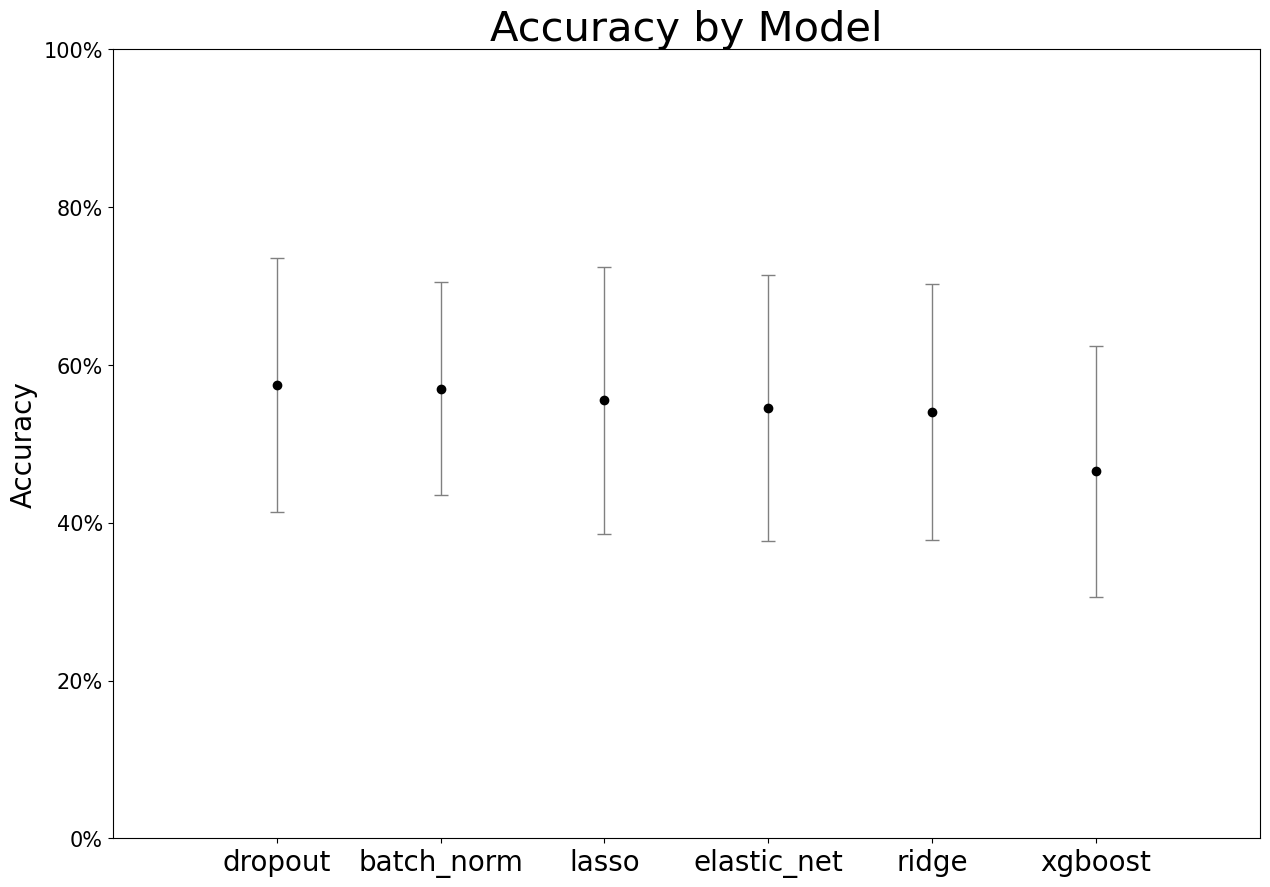

In [94]:
# get names
names_figures = list(df_acc.index)
x_aux = np.arange(len(names_figures))

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(
    x_aux,
    df_acc['mean'],
    yerr = df_acc['std'],
    capsize=5,
    elinewidth=1,
    color ='black',
    ecolor='gray',
    fmt='o'
)

# add decorators
plt.title("Accuracy by Model", fontsize=30)
ax.set_ylabel('Accuracy', fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylim(bottom=0, top=1)
plt.xticks(x_aux, names_figures, fontsize=20)
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)

# reescale plot
fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])

# save plot #
if not os.path.exists("Figures_Colab"):
  os.makedirs("Figures_Colab")

# generate lasso folder
final_folder = "Figures_Colab/BestModels"
if not os.path.exists(final_folder):
  os.makedirs(final_folder)

# save figure
filename = final_folder + "/" + "accuracy_models.png"
plt.savefig(filename, bbox_inches='tight')

# show figure
plt.show()

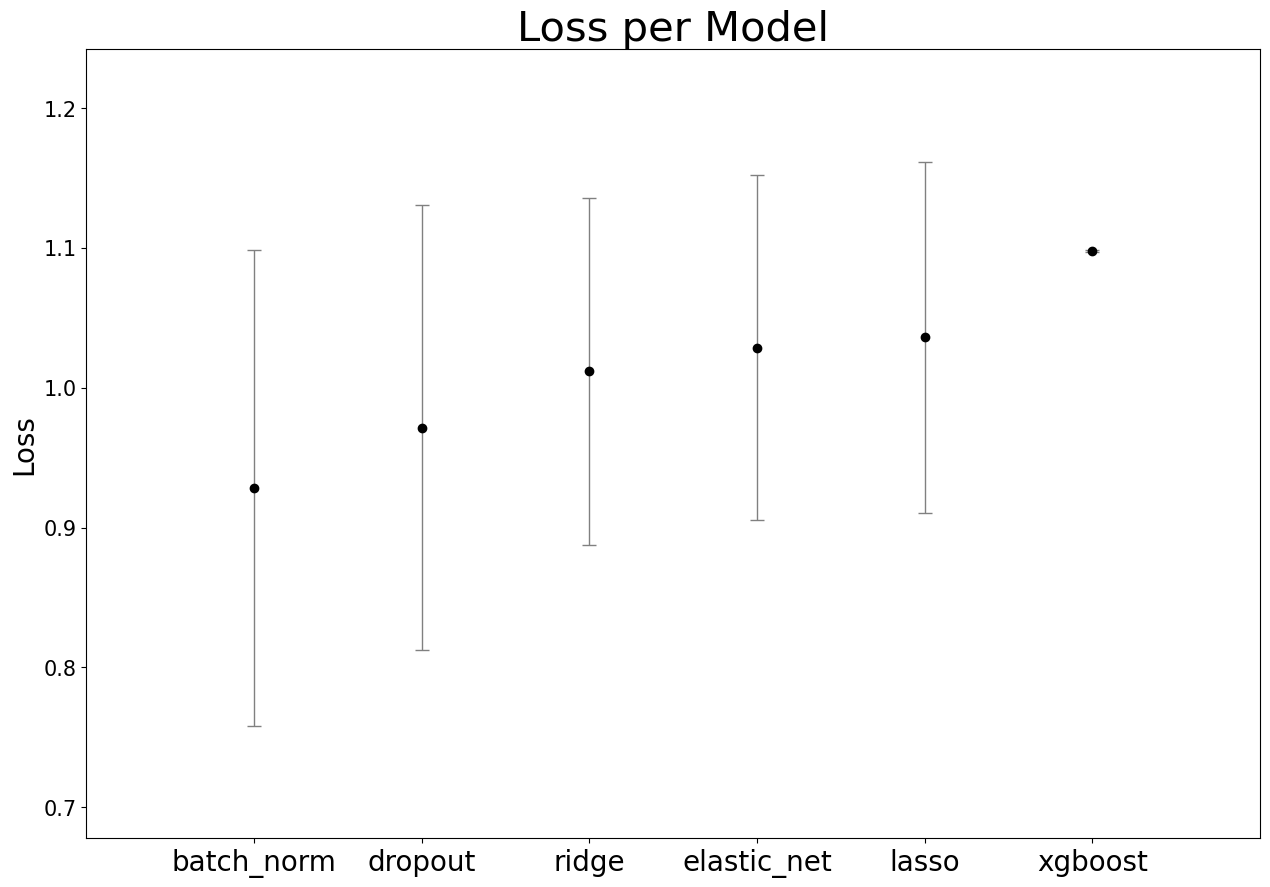

In [96]:
# get names
names_figures = list(df_loss.index)
x_aux = np.arange(len(names_figures))

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(
    x_aux,
    df_loss['mean'],
    yerr = df_loss['std'],
    capsize=5,
    elinewidth=1,
    color ='black',
    ecolor='gray',
    fmt='o'
)

# add decorators
plt.title("Loss per Model", fontsize=30)
ax.set_ylabel('Loss', fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
plt.xticks(x_aux, names_figures, fontsize=20)
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)

# reescale plot
fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])

# save plot #
if not os.path.exists("Figures_Colab"):
  os.makedirs("Figures_Colab")

# generate lasso folder
final_folder = "Figures_Colab/BestModels"
if not os.path.exists(final_folder):
  os.makedirs(final_folder)

# save figure
filename = final_folder + "/" + "precision_models.png"
plt.savefig(filename, bbox_inches='tight')

# show figure
plt.show()

## Selection of best model and Prediction

### Select best model and train with ONLY train

In [100]:
import numpy as np
import sklearn.metrics as sk_metrics
import os

# 1) Grab un‑trained instances with best hyperparams:
fitnn_best = get_hypermodel(tuner_do)          # Keras net
fitnn_xgb  = best_xgb     # XGBClassifier

# --- 2) Evaluate Keras model as before ---
print("=== Keras (dropout) ===")
fit_model(
    dbb,
    fitnn_best,
    rho=1e-3,
    seed=SEED_VALUE,
    model_type='keras'
)

# Test data
X_test = dbb['test']['X'].astype('float32')
y_test = dbb['test']['y'].astype('float32')

# Predict & evaluate
preds_keras     = fitnn_best.predict(X_test)
errors_keras    = fitnn_best.evaluate(X_test, y_test, verbose=1)
print("Keras [loss, accuracy]:", errors_keras)


# --- 3) Train & evaluate XGBoost from scratch ---
print("\n=== XGBoost ===")
# Convert one‑hot → integer labels for train/val
y_train_int = np.argmax(dbb['train']['y'].values, axis=1)
y_val_int   = np.argmax(dbb['validation']['y'].values, axis=1)

# Fit XGB with early stopping
fitnn_xgb.set_params(early_stopping_rounds=10)
fitnn_xgb.fit(
    dbb['train']['X'], y_train_int,
    eval_set=[(dbb['validation']['X'], y_val_int)],
    verbose=False
)

# Now evaluate on test set
y_test_int    = np.argmax(dbb['test']['y'].values, axis=1)
proba_xgb     = fitnn_xgb.predict_proba(dbb['test']['X'])
preds_xgb     = fitnn_xgb.predict(dbb['test']['X'])

logloss_xgb   = sk_metrics.log_loss(y_test_int, proba_xgb)
accuracy_xgb  = sk_metrics.accuracy_score(y_test_int, preds_xgb)
print("XGBoost [log_loss, accuracy]:", [logloss_xgb, accuracy_xgb])

=== Keras (dropout) ===
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4915 - loss: 1.0639 
Keras [loss, accuracy]: [1.0350985527038574, 0.5199999809265137]

=== XGBoost ===
XGBoost [log_loss, accuracy]: [1.0977200015436952, 0.47]


In [102]:
# save model
# generate model folder
folder_results = "Results/Final_Model"

# --- For Keras model (fitnn_best) ---
name_file_model_keras = folder_results + "/final_modelnn.h5"  # Keras model filename
if not os.path.exists(folder_results):
    os.makedirs(folder_results)
fitnn_best.save(name_file_model_keras, save_format='h5')  # Save Keras model

# --- For XGBoost model (fitnn_xgb) ---
name_file_model_xgb = folder_results + "/final_model_xgboost.json"  # XGBoost model filename
fitnn_xgb.save_model(name_file_model_xgb)  # Save XGBoost model

### Predictions of probabilities for all the database

In [106]:
import os
import numpy as np
import pandas as pd

# 1) Assemble the full feature matrix in the same order as df_r
X_all = pd.concat([
    dbb['train']['X'],
    dbb['validation']['X'],
    dbb['test']['X']
]).astype('float32')

# 2) Predict probabilities on every row
#    This is where array_prediction gets defined
array_prediction = fitnn_xgb.predict_proba(X_all)

# 3) Build your prediction DataFrame
df_predict = pd.DataFrame(
    array_prediction,
    columns=['hatproba_away', 'hatproba_draw', 'hatproba_home']
)

df_r_subset = df_r[['season', 'matchweek', 'hometeam', 'awayteam']].reset_index(drop=True)

df_prediction = pd.concat([df_r_subset, df_predict], axis=1)

# 4) Save to CSV
folder_results = "Results/Predictions"
os.makedirs(folder_results, exist_ok=True)

filename = os.path.join(folder_results, "prediction_all_epl.csv")
df_prediction.to_csv(filename, index=False)

print(f"Saved predictions to {filename}")

Saved predictions to Results/Predictions/prediction_all_epl.csv


### Evaluation of best model

Given the `test` dataset:

- Get confusion matrix for the model and for pinnacle sports estimates.
- Look acc & loss for both in _test_.


In [108]:
# init and get params
y_observed = dbb['test']['y'].to_numpy()
y_hat_model = (
        df_prediction
        .query("season == 20 & matchweek > 18")
        [['hatproba_away', 'hatproba_draw', 'hatproba_home']]
        .to_numpy()
    )
y_hat_pinnacle = (
        df_r
        .query("season == 20 & matchweek > 18")
        [['proba_a', 'proba_d', 'proba_h']]
        .to_numpy()
    )

labels_predict = ['away', 'draw', 'home']

#### Confusion Matrix

In [110]:
# confusion matrix
df_cm_model = conf_matrx(
    y_real=y_observed,
    y_hat=y_hat_model,
    labels=labels_predict
)

df_cm_pinnacle = conf_matrx(
    y_real=y_observed,
    y_hat=y_hat_pinnacle,
    labels=labels_predict
)


/var/folders/rz/l57nktg55d92qllkkgk1fwvm0000gn/T/ipykernel_48408/4193832892.py:1579: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(
/var/folders/rz/l57nktg55d92qllkkgk1fwvm0000gn/T/ipykernel_48408/4193832892.py:1579: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(


In [112]:
df_cm_model

,away,draw,home,total_model
away,28,6,50,84.0
draw,16,4,20,40.0
home,9,5,62,76.0
total_predict,53,15,132,NaN


In [114]:
df_cm_pinnacle

,away,draw,home,total_model
away,48,0,36,84.0
draw,25,0,15,40.0
home,21,0,55,76.0
total_predict,94,0,106,NaN


#### loss

In [128]:
import numpy as np
import sklearn.metrics as sk_metrics
from tensorflow import keras
from tensorflow.keras.losses import KLDivergence

# --- 1) True labels ---
# one-hot and integer versions
y_observed = dbb['test']['y'].values.astype('float32')
y_test_int = np.argmax(y_observed, axis=1)

# --- 2) Keras model metrics ---
X_test      = dbb['test']['X'].astype('float32')
y_hat_model = fitnn_best.predict(X_test)

kld_fn     = KLDivergence()
ce_model   = keras.losses.categorical_crossentropy(
                 y_observed, y_hat_model
             ).numpy().mean()
kld_model  = kld_fn(y_observed, y_hat_model).numpy().mean()

# --- 3) XGBoost model metrics ---
y_hat_xgb = fitnn_xgb.predict_proba(X_test)
# clip to avoid log(0)
y_hat_xgb = np.clip(y_hat_xgb, 1e-15, 1 - 1e-15)

# cross-entropy (log-loss)
ce_xgb  = sk_metrics.log_loss(y_test_int, y_hat_xgb)

# KLD via -log p_true
kld_xgb = np.mean(
    -np.log(y_hat_xgb[np.arange(len(y_test_int)), y_test_int])
)

# --- 4) Dataset entropies ---
# overall test‐set entropy
entr = keras.losses.categorical_crossentropy(
    y_observed,
    np.tile(y_observed.mean(axis=0), (len(y_observed), 1))
).numpy().mean()

# historic (train+val) entropy
y_obs_hist = np.vstack([
    dbb['train']['y'].values.astype('float32'),
    dbb['validation']['y'].values.astype('float32')
])
entr_hist = keras.losses.categorical_crossentropy(
    y_obs_hist,
    np.tile(y_obs_hist.mean(axis=0), (len(y_obs_hist), 1))
).numpy().mean()

# --- 5) Print results ---
print(f"Complete dataset entropy:       {entr:.8f}")
print(f"Historic (train+val) entropy:    {entr_hist:.8f}\n")
print(f"Keras Model —  CE: {ce_model:.4f},  KLD: {kld_model:.4f}")
print(f"XGBoost Model —  CE: {ce_xgb:.4f},  KLD: {kld_xgb:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Complete dataset entropy:       1.05391967
Historic (train+val) entropy:    1.06308675

Keras Model —  CE: 1.0351,  KLD: 1.0351
XGBoost Model —  CE: 1.0977,  KLD: 1.0977


# Save

In [132]:
import os

# 1) Make sure your output directories exist
os.makedirs("cache",                exist_ok=True)
os.makedirs("Results/Final_Model",  exist_ok=True)
os.makedirs("Results/Predictions",  exist_ok=True)
os.makedirs("Figures/BestModels",   exist_ok=True)

# 2) Save your trained models
fitnn_best.save("Results/Final_Model/final_modelnn.keras")            # Keras native format
fitnn_xgb.save_model("Results/Final_Model/final_model_xgboost.json")  # XGBoost JSON

# 3) Save your full‐dataset predictions
df_prediction.to_csv(
    "Results/Predictions/prediction_all_epl.csv",
    index=False
)

# 4) Save your figures
plt.savefig(
    "Figures/BestModels/accuracy_models.png",
    bbox_inches="tight"
)
# …repeat for any other plots…

<Figure size 640x480 with 0 Axes>

## Save plots & Files

Save plots & results saved previously in **Figures_Colab**

In [134]:
import os
import shutil

# 1) Define your source & destination folders
src_figures = "Figures_Colab"
dst_figures = "Figures_Backup"   # or whatever local dir you prefer

src_results = "Results"
dst_results = "Results_Backup"

# 2) Make sure the destination parents exist
os.makedirs(dst_figures, exist_ok=True)
os.makedirs(dst_results, exist_ok=True)

# 3) Copy entire folders (overwrite if they already exist)
shutil.copytree(src_figures, dst_figures, dirs_exist_ok=True)
shutil.copytree(src_results, dst_results, dirs_exist_ok=True)

print(f"Copied {src_figures} → {dst_figures}")
print(f"Copied {src_results} → {dst_results}")


Copied Figures_Colab → Figures_Backup
Copied Results → Results_Backup


In [ ]:
%cd "/content/cloned-repo"

In [ ]:
%ls "Results/" -R